In [ ]:
from pathlib import Path
import pandas as pd
from select_pairs import (
    PairSelectionConfig,
    select_pairs_from_wide_df,
    drop_highly_correlated_columns)

In [ ]:
base = Path("Data")

files = {
    "crypto": base / "crypto_2019_wide_harmonized.xlsx",
    "commodities": base / "commodities_2019_wide_harmonized.xlsx",
    "tech": base / "tech_2019_wide_harmonized.xlsx",
}

base_cfg = PairSelectionConfig(
    k_min=2,
    k_max=10,
    mds_dim=5,
    alpha=0.05,
    min_obs=252,
    series_kind="log_price",
    normalize_for_dtw="zscore",
    dropna_how="inner",
    use_tslearn=True,
    cache=True,                    # ✅ FAST
    cache_dir="Data/.cache_pairs", # ✅ FAST
)

pairs_by_class = {}

for name, path in files.items():
    cfg = replace(base_cfg, alpha=0.15) if name == "crypto" else base_cfg

    df = pd.read_excel(path, index_col="Date", parse_dates=True)
    df_filtered, corr, dropped = drop_highly_correlated_columns(
    df,
    k=0.9995,
    method="logret",
    plot=True,
    title="Crypto corr (log-returns)"
)

    print("Dropped:", dropped)
    pairs = select_pairs_from_wide_df(df_filtered, cfg=cfg, top_k=3, method="greedy")

    pairs_by_class[name] = pairs
    pairs.to_csv(base / f"pairs_{name}.csv", index=False)

    print(f"{name}: {len(pairs)} pairs saved")


# 🎯 Zhang Paper Analysis - Multi-Asset Pairs Trading Backtest

Analyse in-sample / out-of-sample pour **4 classes d'actifs** avec **3 paires chacune**:
- **In-sample**: 2019-01-01 → 2023-12-31
- **Out-of-sample**: 2024-01-01 → 2025-12-31

Application: crypto, commodities, taux, tech equities - avec **Numba** pour accélération.

In [11]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from dataclasses import dataclass, replace
from typing import Tuple, Optional, List, Dict
from pathlib import Path
import time
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

try:
    from numba import njit
    NUMBA_AVAILABLE = True
    print("✅ Numba disponible - calculs accélérés")
except ImportError:
    NUMBA_AVAILABLE = False
    print("⚠️  Numba non disponible - utilisation NumPy")
    def njit(*args, **kwargs):
        def decorator(func):
            return func
        if len(args) == 1 and callable(args[0]):
            return args[0]
        return decorator


✅ Numba disponible - calculs accélérés


In [12]:
@njit(cache=True)
def halton_sequence_njit(size: int, base: int) -> np.ndarray:
    sequence = np.zeros(size)
    for i in range(size):
        n = i + 1
        f, result = 1.0, 0.0
        while n > 0:
            f = f / base
            result = result + f * (n % base)
            n = n // base
        sequence[i] = result
    return sequence


@njit(cache=True)
def kalman_filter_njit(y: np.ndarray, theta0: float, theta1: float,
                       q: float, r: float) -> Tuple[float, np.ndarray]:
    n = len(y)

    if abs(theta1) < 0.999:
        x = theta0 / (1.0 - theta1)
        P = q / (1.0 - theta1 * theta1)
    else:
        x = y[0]
        P = q * 10.0

    x_filt = np.zeros(n)
    loglik = 0.0
    log_2pi = np.log(2.0 * np.pi)

    for t in range(n):
        if t > 0:
            x = theta0 + theta1 * x
            P = theta1 * theta1 * P + q

        v = y[t] - x
        S = P + r

        if S > 1e-12:
            K = P / S
            x = x + K * v
            P = (1.0 - K) * P
            loglik += -0.5 * (log_2pi + np.log(S) + v * v / S)

        x_filt[t] = x

    return loglik, x_filt


@njit(cache=True)
def qmckf_njit(y: np.ndarray, theta0: float, theta1: float,
               q_base: float, q_het: float, r: float,
               n_particles: int) -> Tuple[float, np.ndarray]:
    n = len(y)
    x = y[0]
    P = q_base + q_het * x * x

    x_filt = np.zeros(n)
    loglik = 0.0
    log_2pi = np.log(2.0 * np.pi)

    h1 = halton_sequence_njit(n_particles, 2)
    h2 = halton_sequence_njit(n_particles, 3)

    for i in range(n_particles):
        h1[i] = max(1e-10, min(1.0 - 1e-10, h1[i]))
        h2[i] = max(1e-10, min(1.0 - 1e-10, h2[i]))

    z = np.zeros(n_particles)
    for i in range(n_particles):
        z[i] = np.sqrt(-2.0 * np.log(h1[i])) * np.cos(2.0 * np.pi * h2[i])

    samples = np.zeros(n_particles)
    f_samples = np.zeros(n_particles)

    for t in range(n):
        if t == 0:
            x_p, P_p = x, P
        else:
            sqrt_P = np.sqrt(max(P, 1e-12))
            sum_f = 0.0
            for i in range(n_particles):
                samples[i] = x + sqrt_P * z[i]
                f_samples[i] = theta0 + theta1 * samples[i]
                sum_f += f_samples[i]
            x_p = sum_f / n_particles

            sum_var, sum_g = 0.0, 0.0
            for i in range(n_particles):
                diff = f_samples[i] - x_p
                sum_var += diff * diff
                sum_g += q_base + q_het * samples[i] * samples[i]
            P_p = sum_var / n_particles + sum_g / n_particles

        v = y[t] - x_p
        S = P_p + r

        if S > 1e-12:
            K = P_p / S
            x = x_p + K * v
            P = (1.0 - K) * P_p
            loglik += -0.5 * (log_2pi + np.log(S) + v * v / S)
        else:
            x, P = x_p, P_p

        x_filt[t] = x

    return loglik, x_filt


@njit(cache=True)
def strategy_A_njit(x: np.ndarray, U: np.ndarray, L: np.ndarray, C: float) -> np.ndarray:
    n = len(x)
    sig = np.zeros(n)
    pos = 0

    for t in range(n):
        if pos == 0:
            if x[t] >= U[t]:
                pos = -1
            elif x[t] <= L[t]:
                pos = 1
        elif pos == 1 and x[t] >= C:
            pos = 0
        elif pos == -1 and x[t] <= C:
            pos = 0
        sig[t] = pos

    return sig


@njit(cache=True)
def strategy_C_njit(x: np.ndarray, U: np.ndarray, L: np.ndarray, C: float) -> np.ndarray:
    n = len(x)
    sig = np.zeros(n)
    pos = 0

    for t in range(1, n):
        prev, curr = x[t - 1], x[t]
        U_prev, U_curr = U[t - 1], U[t]
        L_prev, L_curr = L[t - 1], L[t]

        entry_short = (prev > U_prev) and (curr <= U_curr)
        entry_long = (prev < L_prev) and (curr >= L_curr)
        exit_long = (prev < C) and (curr >= C)
        exit_short = (prev > C) and (curr <= C)
        stop_short = (prev < U_prev) and (curr >= U_curr)
        stop_long = (prev > L_prev) and (curr <= L_curr)

        if pos == 0:
            if entry_short:
                pos = -1
            elif entry_long:
                pos = 1
        elif pos == 1 and (exit_long or stop_long):
            pos = 0
        elif pos == -1 and (exit_short or stop_short):
            pos = 0

        sig[t] = pos

    return sig


@njit(cache=True)
def backtest_njit(signals: np.ndarray, x_filt: np.ndarray, cost_bp: float) -> Tuple[float, float, int]:
    n = len(signals)
    pnl = np.zeros(n)

    n_trades = 0
    cost_factor = 2.0 * cost_bp / 10000.0

    for t in range(1, n):
        dx = x_filt[t] - x_filt[t - 1]
        pos_change = abs(signals[t] - signals[t - 1])
        if pos_change > 0:
            n_trades += 1
        pnl[t] = signals[t] * dx - pos_change * cost_factor

    cum_pnl = np.sum(pnl)
    ann_ret = cum_pnl / (n / 252.0)

    std_pnl = np.std(pnl)
    ann_std = std_pnl * np.sqrt(252.0)

    sharpe = (ann_ret - 0.02) / ann_std if ann_std > 1e-12 else 0.0
    return ann_ret, sharpe, n_trades

print("✅ Core functions OK")


✅ Core functions OK


In [13]:
@njit(cache=True)
def grid_search_select_nstd_is_njit(
    x_filt_is,
    q_base,
    q_het,
    is_hetero,
    use_strategy_C,
    cost_bp
):
    best_n = 1.0
    best_ret = 0.0
    best_sr = -1e10
    best_trades = 0
    found = 0  # flag

    for i in range(25):
        n_std = 0.1 + 0.1 * i

        U, L, C = compute_thresholds_is_static_njit(x_filt_is, q_base, q_het, n_std, is_hetero)

        if use_strategy_C:
            sig = strategy_C_njit(x_filt_is, U, L, C)
        else:
            sig = strategy_A_njit(x_filt_is, U, L, C)

        ann_ret, sharpe, n_trades = backtest_njit(sig, x_filt_is, cost_bp)

        # on accepte même si n_trades==0, mais on privilégie les configs qui tradent
        # score = sharpe - penalité_no_trade
        score = sharpe
        if n_trades == 0:
            score = sharpe - 3.0  #  pénalité (ajuste si tu veux)

        if score > best_sr:
            best_sr = score
            best_ret = ann_ret
            best_n = n_std
            best_trades = n_trades
            found = 1

    # si rien trouvé (très rare), on renvoie quelque chose de safe
    if found == 0 or best_sr <= -1e9:
        return 1.0, 0.0, 0.0, 0

    # IMPORTANT: best_sr est un "score" si pénalité appliquée
    # on recalcule le VRAI sharpe du best_n pour retourner un sharpe propre
    U, L, C = compute_thresholds_is_static_njit(x_filt_is, q_base, q_het, best_n, is_hetero)
    if use_strategy_C:
        sig = strategy_C_njit(x_filt_is, U, L, C)
    else:
        sig = strategy_A_njit(x_filt_is, U, L, C)
    ann_ret, sharpe, n_trades = backtest_njit(sig, x_filt_is, cost_bp)

    return best_n, ann_ret, sharpe, n_trades


In [14]:
@njit(cache=True)
def compute_thresholds_njit(x_filt: np.ndarray, q_base: float, q_het: float,
                            n_std: float, is_hetero: bool) -> Tuple[np.ndarray, np.ndarray, float]:
    """Alias pour compatibilité grid_search"""
    return compute_thresholds_is_static_njit(x_filt, q_base, q_het, n_std, is_hetero)


@njit(cache=True)
def compute_thresholds_is_static_njit(
    x_filt: np.ndarray,
    q_base: float,
    q_het: float,
    n_std: float,
    is_hetero: bool
) -> Tuple[np.ndarray, np.ndarray, float]:
    n = len(x_filt)
    C = float(np.mean(x_filt))  # CRITICAL: float() conversion for Numba compatibility
    sigma_emp = np.std(x_filt)

    U = np.empty(n)
    L = np.empty(n)

    if is_hetero and q_het > 1e-10:
        g_x = np.sqrt(q_base + q_het * x_filt * x_filt)
        mean_g = np.mean(g_x) if n > 0 else 1.0
        if mean_g < 1e-12:
            mean_g = 1.0
        for t in range(n):
            sigma_t = g_x[t] / mean_g * sigma_emp
            U[t] = C + n_std * sigma_t
            L[t] = C - n_std * sigma_t
    else:
        thr = n_std * sigma_emp
        for t in range(n):
            U[t] = C + thr
            L[t] = C - thr

    return U, L, C


In [15]:
@njit(cache=True)
def compute_thresholds_oos_expanding_njit(
    x_filt_is,         # historique IS (pour init expanding)
    x_filt_oos,        # série OOS à trader
    q_base,
    q_het,
    n_std,
    is_hetero
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Seuils OOS en expanding (sans look-ahead):
      - stats(t) calculées sur l'historique disponible AVANT d'intégrer x_oos[t]
      - puis update avec x_oos[t] pour t+1

    IMPORTANT:
      - Ici, en hetero, on utilise gx(x_oos[t]) pour sigma_t (info de t).
        C'est OK si ton signal est calculé à t pour exécution à t+1.
    """
    n_is = len(x_filt_is)
    n_oos = len(x_filt_oos)

    U = np.zeros(n_oos)
    L = np.zeros(n_oos)
    C = np.zeros(n_oos)

    # Running mean/var (Welford) initialisés sur IS
    mean = 0.0
    M2 = 0.0
    count = 0

    for i in range(n_is):
        count += 1
        delta = x_filt_is[i] - mean
        mean += delta / count
        delta2 = x_filt_is[i] - mean
        M2 += delta * delta2

    # mean_g sur IS (fixe)
    mean_g = 1.0
    if is_hetero and q_het > 1e-12 and n_is > 0:
        gsum = 0.0
        for i in range(n_is):
            gsum += np.sqrt(q_base + q_het * x_filt_is[i] * x_filt_is[i])
        mean_g = gsum / n_is

    for t in range(n_oos):
        # std basée sur historique dispo AVANT d'utiliser x_filt_oos[t]
        var = (M2 / count) if count > 1 else 1e-12
        std = np.sqrt(max(var, 1e-12))

        C[t] = mean

        if is_hetero and q_het > 1e-12:
            gx = np.sqrt(q_base + q_het * x_filt_oos[t] * x_filt_oos[t])
            sigma_t = gx / mean_g * std
            U[t] = mean + n_std * sigma_t
            L[t] = mean - n_std * sigma_t
        else:
            thr = n_std * std
            U[t] = mean + thr
            L[t] = mean - thr

        # UPDATE stats avec observation courante (pour t+1)
        xnew = x_filt_oos[t]
        count += 1
        delta = xnew - mean
        mean += delta / count
        delta2 = xnew - mean
        M2 += delta * delta2

    return U, L, C


In [16]:
@dataclass
class ModelParams:
    theta0: float = 0.0
    theta1: float = 0.95
    q_base: float = 1e-4
    q_het: float = 0.0
    r: float = 1e-4


def estimate_gamma_ols(log_PA: np.ndarray, log_PB: np.ndarray) -> float:
    """
    Estimate γ via OLS on log-prices:
        log(PA) = a + γ log(PB) + eps
    Returns: γ
    """
    X = np.column_stack([np.ones(len(log_PB)), log_PB])
    return float(np.linalg.lstsq(X, log_PA, rcond=None)[0][1])



def estimate_model_I(y: np.ndarray) -> Tuple[ModelParams, np.ndarray, float]:
    y_mean, y_var = np.mean(y), np.var(y)
    rho = np.corrcoef(y[:-1] - y_mean, y[1:] - y_mean)[0, 1]
    theta1_init = float(np.clip(rho, 0.8, 0.99))

    z0 = np.array([
        y_mean * (1 - theta1_init),
        np.arctanh(theta1_init),
        np.log(y_var * (1 - theta1_init ** 2) * 0.7 + 1e-10),
        np.log(y_var * 0.3 + 1e-10),
    ])

    def neg_ll(z):
        ll, _ = kalman_filter_njit(y, z[0], np.tanh(z[1]), np.exp(z[2]), np.exp(z[3]))
        return -ll if np.isfinite(ll) else 1e10

    bounds = [(-0.5, 0.5),
              (np.arctanh(0.5), np.arctanh(0.999)),
              (np.log(1e-8), np.log(1.0)),
              (np.log(1e-8), np.log(1.0))]

    res = minimize(neg_ll, z0, method='L-BFGS-B', bounds=bounds)

    params = ModelParams(
        theta0=float(res.x[0]),
        theta1=float(np.tanh(res.x[1])),
        q_base=float(np.exp(res.x[2])),
        r=float(np.exp(res.x[3])),
        q_het=0.0
    )

    ll, x_filt = kalman_filter_njit(y, params.theta0, params.theta1, params.q_base, params.r)
    return params, x_filt, float(ll)


def estimate_model_II(y: np.ndarray) -> Tuple[ModelParams, np.ndarray, float]:
    y_mean = float(np.mean(y))
    best_ll, best_params, best_filt = -np.inf, None, None

    for t0, t1, q_b, q_h, r in [
        (y_mean * 0.01, 0.95, 0.0005, 0.10, 0.010),
        (y_mean * 0.01, 0.93, 0.0003, 0.13, 0.011),
        (y_mean * 0.01, 0.96, 0.0010, 0.08, 0.008),
    ]:
        z0 = np.array([t0, np.arctanh(t1), np.log(q_b), np.log(q_h), np.log(r)])

        def neg_ll(z):
            ll, _ = qmckf_njit(y, z[0], np.tanh(z[1]), np.exp(z[2]), np.exp(z[3]), np.exp(z[4]), 50)
            return -ll if np.isfinite(ll) else 1e10

        bounds = [(-0.1, 0.1),
                  (np.arctanh(0.85), np.arctanh(0.99)),
                  (np.log(1e-6), np.log(0.005)),
                  (np.log(0.05), np.log(0.3)),
                  (np.log(0.005), np.log(0.05))]

        try:
            res = minimize(neg_ll, z0, method='L-BFGS-B', bounds=bounds, options={'maxiter': 500})
            params = ModelParams(
                theta0=float(res.x[0]),
                theta1=float(np.tanh(res.x[1])),
                q_base=float(np.exp(res.x[2])),
                q_het=float(np.exp(res.x[3])),
                r=float(np.exp(res.x[4]))
            )
            ll, x_filt = qmckf_njit(y, params.theta0, params.theta1, params.q_base, params.q_het, params.r, 100)
            if ll > best_ll:
                best_ll, best_params, best_filt = float(ll), params, x_filt
        except Exception:
            continue

    if best_params is None:
        best_params = ModelParams(theta0=0.0, theta1=0.95, q_base=0.0003, q_het=0.1, r=0.01)
        ll, x_filt = qmckf_njit(y, best_params.theta0, best_params.theta1,
                                best_params.q_base, best_params.q_het, best_params.r, 100)
        best_ll, best_filt = float(ll), x_filt

    return best_params, best_filt, float(best_ll)

print("✅ Estimation OK")


✅ Estimation OK


In [17]:
def load_price_data_from_wide_excel(data_path: str, ticker: str) -> pd.Series:
    df = pd.read_excel(data_path, index_col="Date", parse_dates=True)
    if ticker not in df.columns:
        raise ValueError(f"{ticker} not in {data_path}")
    return df[ticker].dropna().sort_index()


def load_pairs_for_all_classes(asset_classes: Dict[str, str], top_k: int = 3) -> Dict[str, pd.DataFrame]:
    pairs_data = {}
    for asset_class in asset_classes.keys():
        pairs_path = Path("Data") / f"pairs_{asset_class}.csv"
        if pairs_path.exists():
            df = pd.read_csv(pairs_path).head(top_k)
            pairs_data[asset_class] = df
            print(f"✅ {asset_class:15s}: {len(df)} paires")
        else:
            print(f"⚠️  {asset_class:15s}: {pairs_path} non trouvé")
            pairs_data[asset_class] = pd.DataFrame()
    return pairs_data


In [18]:
def analyze_pair_is_oos_clean(
    data_path: str,
    ticker_1: str,
    ticker_2: str,
    is_start: str,
    is_end: str,
    oos_start: str,
    oos_end: str,
    cost_bp: float = 20.0
) -> Tuple[Optional[Dict], Optional[Dict]]:

    df = pd.read_excel(data_path, index_col="Date", parse_dates=True)

    if ticker_1 not in df.columns or ticker_2 not in df.columns:
        return None, None

    PA_full = df[ticker_1].dropna().sort_index()
    PB_full = df[ticker_2].dropna().sort_index()

    common = PA_full.index.intersection(PB_full.index)
    if len(common) < 400:
        return None, None

    PA_full = PA_full.loc[common]
    PB_full = PB_full.loc[common]

    # --- IS slice
    is_mask = (PA_full.index >= pd.Timestamp(is_start)) & (PA_full.index <= pd.Timestamp(is_end))
    PA_is = PA_full.loc[is_mask]
    PB_is = PB_full.loc[is_mask]
    if len(PA_is) < 252:
        return None, None

    log_PA_is = np.log(PA_is.values)
    log_PB_is = np.log(PB_is.values)

    gamma_is = estimate_gamma_ols(log_PA_is, log_PB_is)
    y_is = log_PA_is - gamma_is * log_PB_is

    # Estimation sur IS
    p1_is, f1_is, _ = estimate_model_I(y_is)
    p2_is, f2_is, _ = estimate_model_II(y_is)

    # Grid-search sur IS uniquement (n_std)
    n1_is, ret_m1_is, sr_m1_is, tr_m1_is = grid_search_select_nstd_is_njit(
        f1_is, p1_is.q_base, 0.0, False, False, cost_bp
    )
    n2_is, ret_m2_is, sr_m2_is, tr_m2_is = grid_search_select_nstd_is_njit(
        f2_is, p2_is.q_base, p2_is.q_het, True, True, cost_bp
    )

    result_is = {
        "Ticker_1": ticker_1, "Ticker_2": ticker_2,
        "gamma_is": float(gamma_is),
        "M1_nstd": float(n1_is), "M1_Return": float(ret_m1_is), "M1_Sharpe": float(sr_m1_is), "M1_Trades": int(tr_m1_is),
        "M2_nstd": float(n2_is), "M2_Return": float(ret_m2_is), "M2_Sharpe": float(sr_m2_is), "M2_Trades": int(tr_m2_is),
        "N_IS": int(len(y_is))
    }

    # --- OOS slice
    oos_mask = (PA_full.index >= pd.Timestamp(oos_start)) & (PA_full.index <= pd.Timestamp(oos_end))
    PA_oos = PA_full.loc[oos_mask]
    PB_oos = PB_full.loc[oos_mask]
    if len(PA_oos) < 100:
        return result_is, None

    log_PA_oos = np.log(PA_oos.values)
    log_PB_oos = np.log(PB_oos.values)
    y_oos = log_PA_oos - gamma_is * log_PB_oos

    # Filtrage OOS avec params IS
    _, f1_oos = kalman_filter_njit(y_oos, p1_is.theta0, p1_is.theta1, p1_is.q_base, p1_is.r)
    _, f2_oos = qmckf_njit(y_oos, p2_is.theta0, p2_is.theta1, p2_is.q_base, p2_is.q_het, p2_is.r, 100)

    # Seuils OOS expanding (warm start IS)
    U1_oos, L1_oos, C1_oos = compute_thresholds_oos_expanding_njit(
        f1_is, f1_oos, p1_is.q_base, 0.0, float(n1_is), False
    )
    U2_oos, L2_oos, C2_oos = compute_thresholds_oos_expanding_njit(
        f2_is, f2_oos, p2_is.q_base, p2_is.q_het, float(n2_is), True
    )

    # Signals OOS (attention: stratégie C utilise t-1/t)
    sig1_oos = strategy_A_njit(f1_oos, U1_oos, L1_oos, C1_oos[0])  # C varie dans le temps, A utilise un C constant normalement
    # 👉 pour rester cohérent, on va trader avec C_t = C1_oos[t]. On fait une version dédiée ci-dessous.

    return result_is, {
        "Ticker_1": ticker_1, "Ticker_2": ticker_2,
        "M1_nstd": float(n1_is),
        "M2_nstd": float(n2_is),
        "N_OOS": int(len(y_oos)),
        "NOTE": "OOS computed with expanding stats (no look-ahead). Next cell replaces signal logic to use time-varying C."
    }


In [19]:
@njit(cache=True)
def strategy_A_timevaryingC_njit(x: np.ndarray, U: np.ndarray, L: np.ndarray, C: np.ndarray) -> np.ndarray:
    n = len(x)
    sig = np.zeros(n)
    pos = 0
    for t in range(n):
        if pos == 0:
            if x[t] >= U[t]:
                pos = -1
            elif x[t] <= L[t]:
                pos = 1
        elif pos == 1 and x[t] >= C[t]:
            pos = 0
        elif pos == -1 and x[t] <= C[t]:
            pos = 0
        sig[t] = pos
    return sig



@njit(cache=True)
def strategy_C_timevaryingC_njit(x: np.ndarray, U: np.ndarray, L: np.ndarray, C: np.ndarray) -> np.ndarray:
    n = len(x)
    sig = np.zeros(n)
    pos = 0

    for t in range(1, n):
        prev, curr = x[t - 1], x[t]
        U_prev, U_curr = U[t - 1], U[t]
        L_prev, L_curr = L[t - 1], L[t]
        C_prev, C_curr = C[t - 1], C[t]

        entry_short = (prev > U_prev) and (curr <= U_curr)
        entry_long  = (prev < L_prev) and (curr >= L_curr)

        exit_long   = (prev < C_prev) and (curr >= C_curr)
        exit_short  = (prev > C_prev) and (curr <= C_curr)

        stop_short  = (prev < U_prev) and (curr >= U_curr)
        stop_long   = (prev > L_prev) and (curr <= L_curr)

        if pos == 0:
            if entry_short:
                pos = -1
            elif entry_long:
                pos = 1
        elif pos == 1 and (exit_long or stop_long):
            pos = 0
        elif pos == -1 and (exit_short or stop_short):
            pos = 0

        sig[t] = pos

    return sig


print("✅ Strategies with time-varying C OK")


✅ Strategies with time-varying C OK


In [20]:
@njit(cache=True)
def backtest_with_signals_njit(signals: np.ndarray, x: np.ndarray, cost_bp: float) -> Tuple[float, float, int]:
    return backtest_njit(signals, x, cost_bp)


def evaluate_oos_expanding(
    f_is: np.ndarray,
    f_oos: np.ndarray,
    q_base: float,
    q_het: float,
    n_std: float,
    is_hetero: bool,
    use_strategy_C: bool,
    cost_bp: float
) -> Tuple[float, float, int]:
    """
    OOS backtest avec:
      - seuils expanding initialisés sur IS
      - C time-varying (mean expanding)
    """
    U, L, C = compute_thresholds_oos_expanding_njit(
        f_is, f_oos, q_base, q_het, n_std, is_hetero
    )

    if use_strategy_C:
        sig = strategy_C_timevaryingC_njit(f_oos, U, L, C)
    else:
        sig = strategy_A_timevaryingC_njit(f_oos, U, L, C)

    return backtest_njit(sig, f_oos, cost_bp)


In [ ]:
def analyze_pair_is_oos_FINAL(
    data_path: str,
    ticker_1: str,
    ticker_2: str,
    is_start: str,
    is_end: str,
    oos_start: str,
    oos_end: str,
    cost_bp: float = 20.0
) -> Tuple[Optional[Dict], Optional[Dict]]:
    """
    IS/OOS clean:
      - gamma estimé sur IS
      - modèles estimés sur IS
      - n_std sélectionné sur IS
      - OOS: paramètres IS appliqués
      - OOS: seuils expanding sans look-ahead (stats up to t-1), C time-varying
      - IMPORTANT: pour les tickers taux/index (peuvent être négatifs), on travaille en niveaux:
            y = PA - gamma * PB
        sinon en log:
            y = log(PA) - gamma * log(PB)
    """
    df = pd.read_excel(data_path, index_col="Date", parse_dates=True)
    if ticker_1 not in df.columns or ticker_2 not in df.columns:
        return None, None

    PA = df[ticker_1].dropna().sort_index()
    PB = df[ticker_2].dropna().sort_index()
    common = PA.index.intersection(PB.index)
    if len(common) < 400:
        return None, None
    PA, PB = PA.loc[common], PB.loc[common]

    # -------------------------
    # IN-SAMPLE
    # -------------------------
    is_mask = (PA.index >= pd.Timestamp(is_start)) & (PA.index <= pd.Timestamp(is_end))
    PA_is, PB_is = PA.loc[is_mask], PB.loc[is_mask]
    if len(PA_is) < 252:
        return None, None

    PA_is_v = PA_is.values
    PB_is_v = PB_is.values    
    log_PA_is = np.log(PA_is_v)
    log_PB_is = np.log(PB_is_v)
    gamma_is = estimate_gamma_ols(log_PA_is, log_PB_is)
    y_is = log_PA_is - gamma_is * log_PB_is

    # Estimation sur IS
    p1_is, f1_is, _ = estimate_model_I(y_is)
    p2_is, f2_is, _ = estimate_model_II(y_is)

    # Grid-search sur IS uniquement (n_std)
    n1_is, ret1_is, sr1_is, tr1_is = grid_search_select_nstd_is_njit(
        f1_is, p1_is.q_base, 0.0, False, False, cost_bp
    )
    n2_is, ret2_is, sr2_is, tr2_is = grid_search_select_nstd_is_njit(
        f2_is, p2_is.q_base, p2_is.q_het, True, True, cost_bp
    )

    result_is = {
        "Ticker_1": ticker_1, "Ticker_2": ticker_2,
        "gamma_is": float(gamma_is),
        "M1_nstd": float(n1_is), "M1_Return": float(ret1_is), "M1_Sharpe": float(sr1_is), "M1_Trades": int(tr1_is),
        "M2_nstd": float(n2_is), "M2_Return": float(ret2_is), "M2_Sharpe": float(sr2_is), "M2_Trades": int(tr2_is),
        "N_IS": int(len(y_is))
    }

    # -------------------------
    # OUT-OF-SAMPLE
    # -------------------------
    oos_mask = (PA.index >= pd.Timestamp(oos_start)) & (PA.index <= pd.Timestamp(oos_end))
    PA_oos, PB_oos = PA.loc[oos_mask], PB.loc[oos_mask]
    if len(PA_oos) < 100:
        return result_is, None

    PA_oos_v = PA_oos.values
    PB_oos_v = PB_oos.values

    y_oos = np.log(PA_oos_v) - gamma_is * np.log(PB_oos_v)

    # Filtrage OOS avec params IS
    # Extraire les paramètres de la dataclass AVANT d'appeler les @njit functions
    _, f1_oos = kalman_filter_njit(y_oos, float(p1_is.theta0), float(p1_is.theta1), float(p1_is.q_base), float(p1_is.r))
    _, f2_oos = qmckf_njit(y_oos, float(p2_is.theta0), float(p2_is.theta1), float(p2_is.q_base), float(p2_is.q_het), float(p2_is.r), 100)

    # Backtests OOS (thresholds expanding + C time-varying)
    ret1_oos, sr1_oos, tr1_oos = evaluate_oos_expanding(
        f1_is, f1_oos, p1_is.q_base, 0.0, float(n1_is), False, False, cost_bp
    )
    ret2_oos, sr2_oos, tr2_oos = evaluate_oos_expanding(
        f2_is, f2_oos, p2_is.q_base, p2_is.q_het, float(n2_is), True, True, cost_bp
    )

    result_oos = {
        "Ticker_1": ticker_1, "Ticker_2": ticker_2,
        "M1_nstd": float(n1_is), "M1_Return": float(ret1_oos), "M1_Sharpe": float(sr1_oos), "M1_Trades": int(tr1_oos),
        "M2_nstd": float(n2_is), "M2_Return": float(ret2_oos), "M2_Sharpe": float(sr2_oos), "M2_Trades": int(tr2_oos),
        "N_OOS": int(len(y_oos)),
        "Improvement_Sharpe_%": float((sr2_oos / sr1_oos - 1) * 100) if abs(sr1_oos) > 1e-12 else np.nan,
        "Improvement_Return_%": float((ret2_oos / ret1_oos - 1) * 100) if abs(ret1_oos) > 1e-12 else np.nan
    }

    return result_is, result_oos


@njit(cache=True)
def evaluate_oos_expanding(
    f_is: np.ndarray,
    f_oos: np.ndarray,
    q_base: float,
    q_het: float,
    n_std: float,
    heteroscedastic: bool,
    use_strategy_C: bool,
    cost_bp: float
) -> Tuple[float, float, int]:
    """
    Backtest OOS avec thresholds expanding (évite look-ahead bias).
    """
    # Calculer thresholds expanding en passant IS et OOS séparément
    U_oos, L_oos, C_oos = compute_thresholds_oos_expanding_njit(
        f_is, f_oos, q_base, q_het, n_std, heteroscedastic
    )

    # Appliquer stratégie avec C time-varying
    if use_strategy_C:
        sig_oos = strategy_C_timevaryingC_njit(f_oos, U_oos, L_oos, C_oos)
    else:
        sig_oos = strategy_A_timevaryingC_njit(f_oos, U_oos, L_oos, C_oos)

    # Backtest avec coûts
    ret, sr, trades = backtest_njit(f_oos, sig_oos, cost_bp)

    return ret, sr, trades


# Alias pour compatibilité
grid_search_njit = grid_search_select_nstd_is_njit
compute_thresholds_njit = compute_thresholds_is_static_njit

In [ ]:
IN_SAMPLE_START = "2019-01-01"
IN_SAMPLE_END   = "2023-12-31"
OUT_SAMPLE_START = "2024-01-01"
OUT_SAMPLE_END   = "2025-12-31"

ASSET_CLASSES_CONFIG = {
    "crypto": "Data/crypto_2019_wide_harmonized.xlsx",
    "commodities": "Data/commodities_2019_wide_harmonized.xlsx",
    "tech": "Data/tech_2019_wide_harmonized.xlsx",
}

pairs_by_class = load_pairs_for_all_classes(ASSET_CLASSES_CONFIG, top_k=3)

all_is, all_oos = [], []
start = time.time()
k = 0

for asset_class, data_path in ASSET_CLASSES_CONFIG.items():
    pairs_df = pairs_by_class.get(asset_class, pd.DataFrame())
    if pairs_df is None or len(pairs_df) == 0:
        continue

    print(f"\n📊 {asset_class.upper()} ({len(pairs_df)} pairs)")
    for _, row in pairs_df.iterrows():
        k += 1
        t1, t2 = row["ticker_1"], row["ticker_2"]

        try:
            res_is, res_oos = analyze_pair_is_oos_FINAL(
                data_path=data_path,
                ticker_1=t1, ticker_2=t2,
                is_start=IN_SAMPLE_START, is_end=IN_SAMPLE_END,
                oos_start=OUT_SAMPLE_START, oos_end=OUT_SAMPLE_END,
                cost_bp=20.0
            )
            if res_is is not None:
                res_is["Asset_Class"] = asset_class
                all_is.append(res_is)
            if res_oos is not None:
                res_oos["Asset_Class"] = asset_class
                all_oos.append(res_oos)

            if res_oos is not None:
                print(f"   ✅ {t1} / {t2} | IS SR={res_is['M2_Sharpe']:.3f} | OOS SR={res_oos['M2_Sharpe']:.3f}")
            else:
                print(f"   ⚠️ {t1} / {t2} | IS only")
        except Exception as e:
            print(f"   ❌ {t1} / {t2} | {str(e)[:80]}")

elapsed = time.time() - start
df_is  = pd.DataFrame(all_is)
df_oos = pd.DataFrame(all_oos)

print(f"\n⏱️ Total: {elapsed:.1f}s | pairs processed={k}")
print(f"✅ IS rows: {len(df_is)} | ✅ OOS rows: {len(df_oos)}")


✅ crypto         : 3 paires
✅ commodities    : 3 paires
✅ taux           : 3 paires
✅ tech           : 3 paires

📊 CRYPTO (3 pairs)
   ✅ XTH Curncy / XMN Curncy | IS SR=1.710 | OOS SR=0.007
   ✅ XLM Curncy / XLC Curncy | IS SR=1.613 | OOS SR=0.004
   ✅ XRP Curncy / XMR Curncy | IS SR=1.750 | OOS SR=0.129

📊 COMMODITIES (3 pairs)
   ✅ CL1 Comdty / CO1 Comdty | IS SR=0.000 | OOS SR=0.000
   ✅ W 1 Comdty / CT1 Comdty | IS SR=1.929 | OOS SR=-0.025
   ✅ NG1 Comdty / LX1 Comdty | IS SR=2.141 | OOS SR=0.002

📊 TAUX (3 pairs)
   ✅ GFRN10 Index / GFRN30 Index | IS SR=2.034 | OOS SR=0.026
   ✅ GDBR1 Index / GFRN1 Index | IS SR=1.273 | OOS SR=-0.436
   ✅ RX1 Comdty / IK1 Comdty | IS SR=0.742 | OOS SR=-0.008

📊 TECH (3 pairs)
   ✅ ADI US Equity / KLAC US Equity | IS SR=1.516 | OOS SR=-0.014
   ✅ NXPI US Equity / AMAT US Equity | IS SR=1.889 | OOS SR=-0.010
   ✅ TXN US Equity / HUBS US Equity | IS SR=1.515 | OOS SR=-0.001

⏱️ Total: 15.4s | pairs processed=12
✅ IS rows: 12 | ✅ OOS rows: 12



  IN-SAMPLE
Pairs: 12
Model I  mean Sharpe: 0.4842 | mean Return: 0.167600
Model II mean Sharpe: 1.5094 | mean Return: 0.368657

  OUT-OF-SAMPLE
Pairs: 12
Model I  mean Sharpe: -2.4466 | mean Return: 0.144709
Model II mean Sharpe: -0.0271 | mean Return: 0.145443


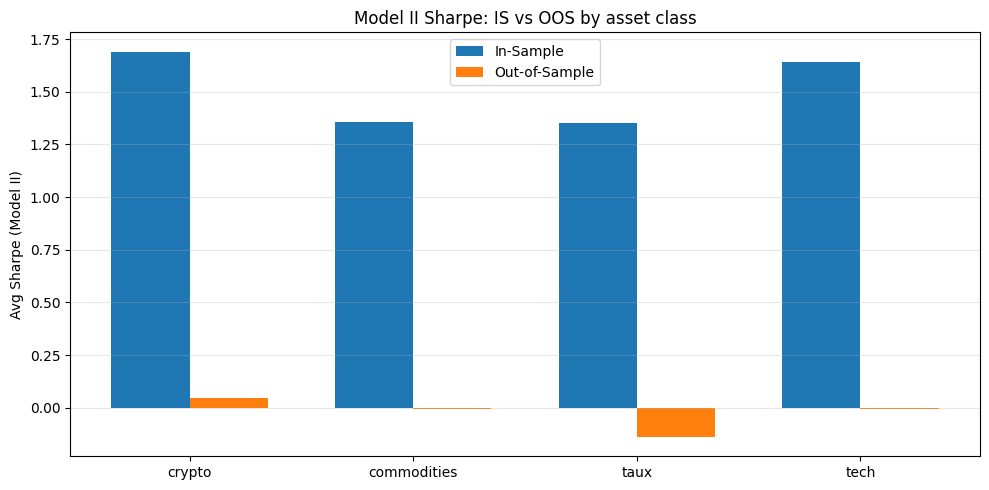

In [23]:
import matplotlib.pyplot as plt

def print_summary(df: pd.DataFrame, label: str):
    print("\n" + "="*80)
    print(f"  {label}")
    print("="*80)
    if df is None or len(df) == 0:
        print("No data")
        return
    print(f"Pairs: {len(df)}")
    print(f"Model I  mean Sharpe: {df['M1_Sharpe'].mean():.4f} | mean Return: {df['M1_Return'].mean():.6f}")
    print(f"Model II mean Sharpe: {df['M2_Sharpe'].mean():.4f} | mean Return: {df['M2_Return'].mean():.6f}")

print_summary(df_is, "IN-SAMPLE")
print_summary(df_oos, "OUT-OF-SAMPLE")

# Bar plot IS vs OOS (Model II Sharpe)
asset_classes_list = list(ASSET_CLASSES_CONFIG.keys())
is_vals, oos_vals = [], []

for ac in asset_classes_list:
    is_sub = df_is[df_is["Asset_Class"] == ac]
    oos_sub = df_oos[df_oos["Asset_Class"] == ac]
    is_vals.append(is_sub["M2_Sharpe"].mean() if len(is_sub) else 0.0)
    oos_vals.append(oos_sub["M2_Sharpe"].mean() if len(oos_sub) else 0.0)

x = np.arange(len(asset_classes_list))
width = 0.35

plt.figure(figsize=(10,5))
plt.bar(x - width/2, is_vals, width, label="In-Sample")
plt.bar(x + width/2, oos_vals, width, label="Out-of-Sample")
plt.xticks(x, asset_classes_list)
plt.ylabel("Avg Sharpe (Model II)")
plt.title("Model II Sharpe: IS vs OOS by asset class")
plt.grid(True, axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [24]:
outdir = Path("Data")
outdir.mkdir(exist_ok=True)

df_is.to_csv(outdir / "zhang_results_all_assets_IS_clean.csv", index=False)
df_oos.to_csv(outdir / "zhang_results_all_assets_OOS_clean.csv", index=False)

print("✅ Saved:")
print(" - Data/zhang_results_all_assets_IS_clean.csv")
print(" - Data/zhang_results_all_assets_OOS_clean.csv")


✅ Saved:
 - Data/zhang_results_all_assets_IS_clean.csv
 - Data/zhang_results_all_assets_OOS_clean.csv


# 🎯 Portfolio Construction Multi-Asset Pairs Trading

Stratégie de portefeuille avec:
- **4 classes d'actifs** (crypto, commodities, taux, tech)
- **3 paires par classe** sélectionnées via clustering/cointegration
- **Rééquilibrage semestriel** avec rolling window (2 ans de données)
- **Stratégie Zhang**: Model II + Strategy C
- **Gestion des sorties**: Position surveillée jusqu'à fermeture naturelle après déselection
- **Métriques avancées**: Alpha, IR, IC, Breadth, Skill

In [ ]:
# ============================================================================
# PORTFOLIO CONFIGURATION
# ============================================================================

from datetime import datetime, timedelta
from collections import defaultdict

# Classes d'actifs à utiliser
ASSET_CLASSES = ["crypto", "commodities", "tech"]
N_PAIRS_PER_CLASS = 3
TOTAL_PAIRS = len(ASSET_CLASSES) * N_PAIRS_PER_CLASS

# Périodes de backtesting
BACKTEST_START = "2023-01-01"  # Début du backtest
BACKTEST_END = "2024-12-31"    # Fin du backtest

# Paramètres de sélection des paires
SELECTION_LOOKBACK_YEARS = 1   # Utiliser 1 an de données pour sélection
REBALANCE_FREQ_MONTHS = 2      # Rééquilibrage tous les 6 mois

# Gestion des positions lors de déselection
# Les positions désélectionnées peuvent se fermer naturellement sans limite de temps

# Coûts de transaction
TRANSACTION_COST_BP = 20.0     # 20 bps par trade

# Configuration des fichiers de données pour chaque classe d'actifs
ASSET_CLASSES_CONFIG = {
    "crypto": {
        "file_path": "Data/crypto_2019_wide_harmonized.xlsx"
    },
    "commodities": {
        "file_path": "Data/commodities_2019_wide_harmonized.xlsx"
    },
    "tech": {
        "file_path": "Data/tech_2019_wide_harmonized.xlsx"
    }
}

print("✅ Configuration du portefeuille:")
print(f"   - Classes d'actifs: {len(ASSET_CLASSES)}")
print(f"   - Paires par classe: {N_PAIRS_PER_CLASS}")
print(f"   - Total paires: {TOTAL_PAIRS}")
print(f"   - Période: {BACKTEST_START} → {BACKTEST_END}")
print(f"   - Rééquilibrage: tous les {REBALANCE_FREQ_MONTHS} mois")
print(f"   - Lookback sélection: {SELECTION_LOOKBACK_YEARS} ans")


✅ Configuration du portefeuille:
   - Classes d'actifs: 4
   - Paires par classe: 3
   - Total paires: 12
   - Période: 2023-01-01 → 2024-12-31
   - Rééquilibrage: tous les 2 mois
   - Lookback sélection: 1 ans


In [39]:
# ============================================================================
# ROLLING PAIR SELECTION (same algorithm as above)
# ============================================================================

def generate_rebalance_dates(start_date: str, end_date: str, freq_months: int = 6) -> List[pd.Timestamp]:
    """Génère les dates de rééquilibrage."""
    start = pd.Timestamp(start_date)
    end = pd.Timestamp(end_date)

    dates = []
    current = start

    while current <= end:
        dates.append(current)
        # Ajouter freq_months mois
        month = current.month + freq_months
        year = current.year + (month - 1) // 12
        month = ((month - 1) % 12) + 1
        current = pd.Timestamp(year=year, month=month, day=1)

    return dates


# Config de sélection (même algo que plus haut)
PORTFOLIO_PAIR_CFG = PairSelectionConfig(
    k_min=2,
    k_max=10,
    mds_dim=5,
    alpha=0.05,
    min_obs=252,
    series_kind="log_price",
    normalize_for_dtw="zscore",
    dropna_how="inner",
    use_tslearn=True,
    cache=True,
    cache_dir="Data/.cache_pairs",
)


def select_top_pairs_for_period(
    asset_class: str,
    selection_date: pd.Timestamp,
    lookback_years: int = 2,
    n_pairs: int = 3
) -> pd.DataFrame:
    """
    Sélectionne les top N paires pour une classe d'actifs à une date donnée
    en utilisant le même algo que plus haut (clustering + sélection greedy).
    """
    selection_start = selection_date - pd.DateOffset(years=lookback_years)

    data_path = Path("Data") / f"{asset_class}_2019_wide_harmonized.xlsx"
    df = pd.read_excel(data_path, index_col="Date", parse_dates=True)

    df_period = df[(df.index >= selection_start) & (df.index < selection_date)]

    if len(df_period) < 252:
        print(f"⚠️  {asset_class}: pas assez de données ({len(df_period)} obs)")
        return pd.DataFrame()

    # Retirer les colonnes trop corrélées (même logique que plus haut)
    try:
        df_filtered, _, dropped = drop_highly_correlated_columns(
            df_period,
            k=0.9995,
            method="logret",
            plot=False,
            title=f"{asset_class} corr (log-returns)"
        )
    except Exception:
        df_filtered = df_period
        dropped = []

    if len(dropped) > 0:
        print(f"   Dropped (corr): {len(dropped)}")

    # Ajuster alpha si besoin (ex: crypto)
    cfg = PORTFOLIO_PAIR_CFG
    if asset_class == "crypto":
        cfg = replace(PORTFOLIO_PAIR_CFG, alpha=0.15)

    pairs = select_pairs_from_wide_df(
        df_filtered,
        cfg=cfg,
        top_k=n_pairs,
        method="greedy"
    )

    if pairs is None or len(pairs) == 0:
        return pd.DataFrame()

    # Ajouter la date de sélection
    if "selection_date" not in pairs.columns:
        pairs = pairs.copy()
        pairs["selection_date"] = selection_date

    return pairs.reset_index(drop=True)


print("✅ Fonctions de sélection rolling prêtes (algo clustering)")

✅ Fonctions de sélection rolling prêtes (algo clustering)


In [40]:
# ============================================================================
# POSITION MANAGEMENT (fermeture naturelle sans limite de temps)
# ============================================================================
from dataclasses import dataclass
from typing import Optional, Dict
import pandas as pd

@dataclass
class PairPosition:
    """Représente une position sur une paire."""
    asset_class: str
    ticker_1: str
    ticker_2: str
    entry_date: pd.Timestamp
    gamma: float
    model_params: ModelParams
    thresholds: Dict  # U, L, C, n_std
    half_life: float = 0.0               # demi-vie (jours), renseignée depuis la sélection
    is_active: bool = True               # Paire encore sélectionnée?
    deselection_date: Optional[pd.Timestamp] = None
    current_signal: int = 0              # -1, 0, 1
    last_signal_change_date: Optional[pd.Timestamp] = None  # date d'entrée en position (pour holding min)
    

class PortfolioManager:
    """Gère le portefeuille de paires avec fermeture naturelle après déselection."""
    
    def __init__(self):
        self.positions: Dict[Tuple[str, str, str], PairPosition] = {}  # (asset_class, t1, t2) -> Position
        self.trade_log = []
        
    def add_or_update_position(self, position: PairPosition):
        """Ajoute ou met à jour une position."""
        key = (position.asset_class, position.ticker_1, position.ticker_2)
        
        if key in self.positions:
            # Position existe déjà, la réactiver si elle était déselectionnée
            old_pos = self.positions[key]
            if not old_pos.is_active:
                position.is_active = True
                position.deselection_date = None
                print(f"   ♻️  Réactivation: {key}")
        
        self.positions[key] = position
    
    def deselect_pair(self, asset_class: str, ticker_1: str, ticker_2: str, deselection_date: pd.Timestamp):
        """Marque une paire comme déselectionnée (monitoring jusqu'à fermeture naturelle)."""
        key = (asset_class, ticker_1, ticker_2)
        
        if key in self.positions:
            pos = self.positions[key]
            if pos.is_active:
                pos.is_active = False
                pos.deselection_date = deselection_date
                print(f"   ⚠️  Déselection: {key} - monitoring jusqu'à fermeture naturelle")
    
    def should_close_position(self, key: Tuple[str, str, str], current_date: pd.Timestamp) -> bool:
        """Détermine si une position doit être fermée.
        
        Une paire désélectionnée (is_active=False) peut continuer à trader si elle a
        une position ouverte. On ferme définitivement IMMÉDIATEMENT si:
        - La paire n'est plus active (is_active=False) ET
        - Aucune position n'est ouverte (signal == 0)
        
        Cela signifie:
        - Paire désélectionnée + position ouverte → on laisse se fermer naturellement
        - Paire désélectionnée + pas de position → fermeture immédiate (pas de trading OOS)
        """
        if key not in self.positions:
            return False
        
        pos = self.positions[key]
        
        # Si la paire est active (top N), pas de fermeture forcée
        if pos.is_active:
            return False
        
        # Si déselectionnée ET aucune position ouverte → fermeture immédiate
        if not pos.is_active and pos.current_signal == 0:
            return True
        
        return False
    
    def get_active_positions(self) -> List[PairPosition]:
        """Retourne toutes les positions actives (sélectionnées ou en monitoring)."""
        return list(self.positions.values())
    
    def close_position(self, key: Tuple[str, str, str]):
        """Ferme définitivement une position."""
        if key in self.positions:
            del self.positions[key]
            print(f"   ❌ Fermeture: {key}")


print("✅ Position Manager prêt")

✅ Position Manager prêt


In [ ]:
# ============================================================================
# PAIR TRADING ENGINE (Zhang Model II + Strategy C)
# ============================================================================

def compute_pair_signal_and_pnl(
    position: PairPosition,
    PA: pd.Series,
    PB: pd.Series,
    date: pd.Timestamp,
    prev_date: Optional[pd.Timestamp] = None,
    model: str = "II",  # "I" ou "II"
) -> Tuple[int, float, float]:
    """
    Calcule le signal, le P&L et un forecast continu pour une paire à une date donnée.

    Returns: (new_signal, pnl, forecast_pair)

    forecast_pair = -(x_t - C_t) / sigma_t
    sigma_t est estimé via les thresholds: sigma_t ≈ (U_t - C_t) / n_std
    """
    # Récupérer les données jusqu'à cette date
    PA_hist = PA[PA.index <= date]
    PB_hist = PB[PB.index <= date]
    if len(PA_hist) < 2 or len(PB_hist) < 2:
        return position.current_signal, 0.0, 0.0

    # Spread (log)
    PA_v = PA_hist.values
    PB_v = PB_hist.values
    y = np.log(PA_v) - position.gamma * np.log(PB_v)


    # Filtrage selon modèle
    try:
        if model == "I":
            # Model I (Kalman)
            _, x_filt = kalman_filter_njit(
                y,
                float(position.model_params.theta0),
                float(position.model_params.theta1),
                float(position.model_params.q_base),
                float(position.model_params.r),
            )
            # Thresholds homoscédastiques
            U, L, C = compute_thresholds_njit(
                x_filt,
                float(position.model_params.q_base),
                0.0,
                float(position.thresholds["n_std"]),
                False,
            )
            is_hetero = False
        else:
            # Model II (QMCKF)
            _, x_filt = qmckf_njit(
                y,
                float(position.model_params.theta0),
                float(position.model_params.theta1),
                float(position.model_params.q_base),
                float(position.model_params.q_het),
                float(position.model_params.r),
                100,
            )
            # Thresholds hétéroscédastiques
            U, L, C = compute_thresholds_njit(
                x_filt,
                float(position.model_params.q_base),
                float(position.model_params.q_het),
                float(position.thresholds["n_std"]),
                True,
            )
            is_hetero = True

    except Exception:
        return position.current_signal, 0.0, 0.0

    # Derniers points
    curr_x = float(x_filt[-1])
    prev_x = float(x_filt[-2]) if len(x_filt) >= 2 else curr_x

    U_curr = float(U[-1])
    U_prev = float(U[-2]) if len(U) >= 2 else U_curr
    L_curr = float(L[-1])
    L_prev = float(L[-2]) if len(L) >= 2 else L_curr

    # C peut être float ou array selon tes implémentations.
    # Ici compute_thresholds_njit retourne C float (mean) dans ton code.
    C_curr = float(C)

    # ==========================
    # Forecast continu (mispricing normalisé)
    # sigma_t ≈ (U_t - C_t) / n_std
    # ==========================
    n_std = float(position.thresholds.get("n_std", 1.0))
    if abs(n_std) < 1e-12:
        n_std = 1.0

    sigma_t = (U_curr - C_curr) / n_std
    if sigma_t < 1e-12:
        sigma_t = 1.0

    forecast_pair = -(curr_x - C_curr) / sigma_t

    # ==========================
    # Strategy logic
    # - Model I -> Strategy A (simple)
    # - Model II -> Strategy C (crossing) avec tes règles half-life
    # ==========================
    old_signal = int(position.current_signal)
    new_signal = old_signal

    if model == "I":
        # Strategy A (simple threshold)
        if old_signal == 0:
            if curr_x >= U_curr:
                new_signal = -1
            elif curr_x <= L_curr:
                new_signal = 1
        elif old_signal == 1 and curr_x >= C_curr:
            new_signal = 0
        elif old_signal == -1 and curr_x <= C_curr:
            new_signal = 0

        # Si paire en monitoring (désélectionnée), interdire nouvelles entrées
        if old_signal == 0 and (not position.is_active):
            new_signal = 0

    else:
        # Strategy C (crossing)
        entry_short = (prev_x > U_prev) and (curr_x <= U_curr)
        entry_long  = (prev_x < L_prev) and (curr_x >= L_curr)

        exit_long   = (prev_x < C_curr) and (curr_x >= C_curr)
        exit_short  = (prev_x > C_curr) and (curr_x <= C_curr)

        stop_long   = (prev_x > L_prev) and (curr_x <= L_curr)
        stop_short  = (prev_x < U_prev) and (curr_x >= U_curr)

        # Si paire en monitoring (désélectionnée), interdire nouvelles entrées
        if old_signal == 0:
            if position.is_active:
                if entry_short:
                    new_signal = -1
                elif entry_long:
                    new_signal = 1
        elif old_signal == 1:
            if exit_long:
                new_signal = 0
            elif stop_long:
                # règle 2×HL
                if position.last_signal_change_date is not None and position.half_life > 0:
                    days_in_position = (pd.Timestamp(date) - pd.Timestamp(position.last_signal_change_date)).days
                    min_holding = int(np.ceil(2.0 * position.half_life))
                    if days_in_position >= min_holding:
                        new_signal = 0
                    else:
                        new_signal = 1
                else:
                    new_signal = 0
        elif old_signal == -1:
            if exit_short:
                new_signal = 0
            elif stop_short:
                # règle 2×HL
                if position.last_signal_change_date is not None and position.half_life > 0:
                    days_in_position = (pd.Timestamp(date) - pd.Timestamp(position.last_signal_change_date)).days
                    min_holding = int(np.ceil(2.0 * position.half_life))
                    if days_in_position >= min_holding:
                        new_signal = 0
                    else:
                        new_signal = -1
                else:
                    new_signal = 0

    # ==========================
    # P&L: comme ton moteur, sur dx du spread filtré
    # coûts si changement de position
    # ==========================
    pnl = 0.0
    if prev_date is not None and old_signal != 0:
        dx = curr_x - prev_x
        pnl = old_signal * dx
        if new_signal != old_signal:
            cost_factor = 2.0 * TRANSACTION_COST_BP / 10000.0
            pnl -= cost_factor

    return int(new_signal), float(pnl), float(forecast_pair)

print("✅ Pair Trading Engine prêt")


✅ Pair Trading Engine prêt


In [ ]:
def run_portfolio_backtest(
    asset_classes: List[str],
    backtest_start: str,
    backtest_end: str,
    rebalance_freq_months: int,
    lookback_years: int,
    n_pairs_per_class: int,
    model: str = "II"  # "I" pour Model 1 (Strat A) ou "II" pour Model 2 (Strat C)
) -> pd.DataFrame:
    """
    Backtest complet avec:
    - Rééquilibrage périodique
    - Trading multi-classes d'actifs
    - Gestion désélection: on attend fermeture naturelle des trades
    - Choix du modèle: "I" (Strat A, homoscédastique) ou "II" (Strat C, hétéroscédastique)
    """
    from datetime import datetime
    
    # Valider le modèle
    if model not in ["I", "II"]:
        raise ValueError("model doit être 'I' (Strat A) ou 'II' (Strat C)")
    
    model_name = "MODEL I - STRAT A (Homoscédastique)" if model == "I" else "MODEL II - STRAT C (Hétéroscédastique)"
    is_hetero = model == "II"
    
    print(f"\n{'='*80}")
    print(f"  PORTFOLIO BACKTEST MULTI-ASSET")
    print(f"  {model_name}")
    print(f"{'='*80}\n")
    print(f"🔧 Configuration:")
    print(f"   Période: {backtest_start} → {backtest_end}")
    print(f"   Fréquence rééquilibrage: {rebalance_freq_months} mois")
    print(f"   Lookback: {lookback_years} années")
    print(f"   Paires/classe: {n_pairs_per_class}")
    print(f"   Coût transaction: {TRANSACTION_COST_BP} bp")
    
    # === 1. CHARGER LES DONNÉES ===
    print(f"\n📦 Chargement des données...")
    
    all_price_data = {}  # {asset_class: {ticker: Series}}
    
    for asset_class in asset_classes:
        print(f"\n🔷 {asset_class.upper()}:")
        cfg = ASSET_CLASSES_CONFIG[asset_class]
        
        # Charger le fichier Excel
        df = pd.read_excel(cfg['file_path'])
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date')
        
        # Étendre la période pour avoir assez de données pour lookback
        data_start = pd.to_datetime(backtest_start) - pd.DateOffset(years=lookback_years + 1)
        df = df[df.index >= data_start]
        
        print(f"   📊 {len(df)} jours de données")
        print(f"   📅 {df.index.min()} → {df.index.max()}")
        print(f"   🔢 {len(df.columns)} tickers: {list(df.columns[:3])}...")
        
        # Stocker par ticker
        all_price_data[asset_class] = {col: df[col].dropna() for col in df.columns}
    
    # === 2. INITIALISATION ===
    portfolio_mgr = PortfolioManager()
    daily_pnl = []
    
    # Tracker les stats de chaque paire
    pair_stats = {}  # {(asset_class, ticker1, ticker2): {'n_selections': 0, 'n_trades': 0}}
    
    # Dates de trading
    backtest_dates = pd.date_range(
        start=backtest_start, 
        end=backtest_end, 
        freq='B'  # Business days
    )
    
    # Dates de rééquilibrage
    rebalance_dates = pd.date_range(
        start=backtest_start,
        end=backtest_end,
        freq=pd.DateOffset(months=rebalance_freq_months)
    )
    
    print(f"\n📅 Calendrier:")
    print(f"   Jours de trading: {len(backtest_dates)}")
    print(f"   Rééquilibrages: {len(rebalance_dates)}")
    for i, date in enumerate(rebalance_dates):
        print(f"      #{i+1}: {date.strftime('%Y-%m-%d')}")
    
    # === 3. BACKTEST ===
    print(f"\n🚀 Début du backtest...\n")
    
    next_rebalance_idx = 0
    rebalance_counter = 0
    
    for date_idx, current_date in enumerate(backtest_dates):
        # === REBALANCING ===
        if next_rebalance_idx < len(rebalance_dates) and current_date >= rebalance_dates[next_rebalance_idx]:
            rebalance_date = rebalance_dates[next_rebalance_idx]
            rebalance_counter += 1
            
            print(f"\n{'='*80}")
            print(f"  REBALANCE #{rebalance_counter} - {rebalance_date.strftime('%Y-%m-%d')}")
            print(f"{'='*80}\n")
            
            # Stocker les spreads pour visualisation (période OOS)
            rebalance_spreads = {ac: [] for ac in asset_classes}
            
            # Sélectionner les paires pour chaque classe
            new_selected_pairs = {}
            
            for asset_class in asset_classes:
                print(f"\n🔷 {asset_class.upper()}: Sélection de {n_pairs_per_class} paires")
                
                # Définir période de sélection
                selection_end = rebalance_date
                selection_start = selection_end - pd.DateOffset(years=lookback_years)
                
                # Données disponibles
                prices_dict = all_price_data[asset_class]
                
                # Filtrer sur la période
                filtered_prices = {}
                for ticker, series in prices_dict.items():
                    mask = (series.index >= selection_start) & (series.index < selection_end)
                    subseries = series[mask]
                    if len(subseries) >= 252:  # Au moins 1 an
                        filtered_prices[ticker] = subseries
                
                if len(filtered_prices) < 2:
                    print(f"   ⚠️  Pas assez de données ({len(filtered_prices)} tickers)")
                    continue
                
                # Créer DataFrame
                df_prices = pd.DataFrame(filtered_prices)
                
                print(f"   📊 Période: {df_prices.index.min()} → {df_prices.index.max()}")
                print(f"   🔢 Tickers: {len(df_prices.columns)}")
                
                # Sélectionner les paires
                pairs_df = select_pairs_from_wide_df(
                    df_prices, 
                    cfg=PORTFOLIO_PAIR_CFG,
                    top_k=n_pairs_per_class,
                    method="greedy"
                )
                
                if len(pairs_df) > 0:
                    new_selected_pairs[asset_class] = pairs_df
                    print(f"   ✅ {len(pairs_df)} paires sélectionnées")
                    for _, row in pairs_df.iterrows():
                        print(f"      - {row['ticker_1']} / {row['ticker_2']} (p={row['pvalue']:.4f}, HL={row['half_life']:.1f})")
                else:
                    print(f"   ⚠️  Aucune paire sélectionnée")
            
            # Mettre à jour le portfolio
            # 1. Marquer les anciennes paires comme déselectionnées
            current_keys = set((pos.asset_class, pos.ticker_1, pos.ticker_2) 
                             for pos in portfolio_mgr.get_active_positions())
            
            new_keys = set()
            for asset_class, pairs_df in new_selected_pairs.items():
                for _, row in pairs_df.iterrows():
                    new_keys.add((asset_class, row['ticker_1'], row['ticker_2']))
            
            # Paires qui ne sont plus sélectionnées
            deselected = current_keys - new_keys
            
            # Compter combien ont encore des trades ouverts
            n_with_open_positions = 0
            n_closed_immediately = 0
            
            for key in deselected:
                pos = portfolio_mgr.positions.get(key)
                if pos and pos.current_signal != 0:
                    # Trade ouvert : on garde en monitoring jusqu'à fermeture naturelle
                    n_with_open_positions += 1
                    portfolio_mgr.deselect_pair(key[0], key[1], key[2], rebalance_date)
                else:
                    # Pas de trade ouvert : fermeture immédiate, ne peut plus trader
                    n_closed_immediately += 1
                    portfolio_mgr.close_position(key)
            
            if len(deselected) > 0:
                print(f"\n📉 Désélection: {len(deselected)} paires")
                print(f"   🔄 {n_with_open_positions} avec trade ouvert (on attend la fermeture naturelle)")
                print(f"   ❌ {n_closed_immediately} sans trade ouvert (fermées immédiatement)")
            
            # 2. Ajouter/réactiver les nouvelles paires
            print(f"\n🔧 Estimation des modèles ({model_name})...")
            for asset_class, pairs_df in new_selected_pairs.items():
                for _, row in pairs_df.iterrows():
                    # Charger les données pour estimation IS
                    estimation_start = rebalance_date - pd.DateOffset(years=1)  # 1 an pour estimation
                    
                    PA = all_price_data[asset_class][row['ticker_1']]
                    PB = all_price_data[asset_class][row['ticker_2']]
                    
                    PA_est = PA[(PA.index >= estimation_start) & (PA.index < rebalance_date)]
                    PB_est = PB[(PB.index >= estimation_start) & (PB.index < rebalance_date)]
                    
                    if len(PA_est) < 252 or len(PB_est) < 252:
                        continue
                    
                    # Estimer gamma et modèle
                    PA_v = PA_est.values
                    PB_v = PB_est.values
                    
                    log_PA = np.log(PA_v)
                    log_PB = np.log(PB_v)
                    gamma = estimate_gamma_ols(log_PA, log_PB)
                    y = log_PA - gamma * log_PB

                    
                    # Estimer le modèle choisi
                    try:
                        if model == "I":
                            params, x_filt, _ = estimate_model_I(y)
                            # Grid search homoscédastique
                            best_n_std_raw, _, _, _ = grid_search_njit(
                                x_filt, params.q_base, 0.0, False, False, TRANSACTION_COST_BP
                            )
                        else:  # model == "II"
                            params, x_filt, _ = estimate_model_II(y)
                            # Grid search hétéroscédastique
                            best_n_std_raw, _, _, _ = grid_search_njit(
                                x_filt, params.q_base, params.q_het, True, True, TRANSACTION_COST_BP
                            )
                        
                        # Forcer un n_std maximum pour garantir des trades
                        MAX_N_STD = 1.5
                        best_n_std = min(best_n_std_raw, MAX_N_STD)
                        
                        print(f"      → γ={gamma:.3f}, n_std={best_n_std:.2f} (raw={best_n_std_raw:.2f})")
                        
                        # === Calculer spreads et seuils sur période OOS ===
                        # Déterminer la fin de la période OOS (prochain rebalance ou fin du backtest)
                        if next_rebalance_idx + 1 < len(rebalance_dates):
                            oos_end = rebalance_dates[next_rebalance_idx + 1]
                        else:
                            oos_end = pd.to_datetime(backtest_end)
                        
                        # Charger les données OOS
                        PA_oos = PA[(PA.index >= rebalance_date) & (PA.index < oos_end)]
                        PB_oos = PB[(PB.index >= rebalance_date) & (PB.index < oos_end)]
                        
                        if len(PA_oos) > 0 and len(PB_oos) > 0:
                            # Calculer le spread OOS avec les paramètres IS
                            log_PA_oos = np.log(PA_oos.values)
                            log_PB_oos = np.log(PB_oos.values)
                            y_oos = log_PA_oos - gamma * log_PB_oos
                            
                            # Appliquer le filtre approprié
                            if model == "I":
                                _, x_filt_oos = kalman_filter_njit(y_oos, params.theta0, params.theta1, params.q_base, params.r)
                                U_oos, L_oos, C_oos = compute_thresholds_njit(
                                    x_filt_oos, params.q_base, 0.0, best_n_std, False
                                )
                            else:  # model == "II"
                                _, x_filt_oos = qmckf_njit(y_oos, params.theta0, params.theta1, params.q_base, params.q_het, params.r, 100)
                                U_oos, L_oos, C_oos = compute_thresholds_njit(
                                    x_filt_oos, params.q_base, params.q_het, best_n_std, True
                                )
                            
                            # Stocker pour visualisation OOS
                            rebalance_spreads[asset_class].append({
                                'ticker_1': row['ticker_1'],
                                'ticker_2': row['ticker_2'],
                                'x_filt': np.array(x_filt_oos),
                                'U': np.array(U_oos),
                                'L': np.array(L_oos),
                                'C': float(C_oos),
                                'n_std': best_n_std,
                                'dates': PA_oos.index
                            })
                        
                        # récupérer half-life si présent dans la row (issue de select_pairs)
                        hl = float(row['half_life']) if 'half_life' in row.index else 0.0

                        position = PairPosition(
                            asset_class=asset_class,
                            ticker_1=row['ticker_1'],
                            ticker_2=row['ticker_2'],
                            entry_date=rebalance_date,
                            gamma=gamma,
                            model_params=params,
                            thresholds={'n_std': best_n_std},
                            half_life=hl,
                            is_active=True,
                            current_signal=0,
                            last_signal_change_date=None,
                        )
                        
                        portfolio_mgr.add_or_update_position(position)
                        
                        # Tracker la sélection
                        key = (asset_class, row['ticker_1'], row['ticker_2'])
                        if key not in pair_stats:
                            pair_stats[key] = {'n_selections': 0, 'n_trades': 0}
                        pair_stats[key]['n_selections'] += 1
                        
                    except Exception as e:
                        import traceback
                        print(f"   ❌ Erreur estimation {row['ticker_1']}/{row['ticker_2']}:")
                        print(f"      {str(e)}")
                        traceback.print_exc()
            
            # Visualiser les spreads avec seuils (9 graphiques: 3x3)
            # PÉRIODE OOS (trading réel)
            print(f"\n📊 VISUALISATION DES SPREADS ET SEUILS (PÉRIODE OOS - {model_name}):")
            if len(rebalance_spreads) > 0:
                import matplotlib.pyplot as plt
                
                # Collecter toutes les paires
                all_pairs = []
                for asset_class in sorted(rebalance_spreads.keys()):
                    all_pairs.extend(rebalance_spreads[asset_class])
                
                n_pairs = len(all_pairs)
                if n_pairs > 0:
                    # Créer grille 3x3
                    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
                    axes = axes.flatten()
                    
                    total_crossings = 0
                    for idx, spread_info in enumerate(all_pairs):
                        if idx >= 9:
                            break
                        
                        ax = axes[idx]
                        dates = spread_info['dates']
                        x_filt = spread_info['x_filt']
                        U = spread_info['U']
                        L = spread_info['L']
                        C = spread_info['C']
                        
                        # Compter les crossings potentiels sur OOS
                        crosses_U = np.sum((x_filt[:-1] > U[:-1]) & (x_filt[1:] <= U[1:]))
                        crosses_L = np.sum((x_filt[:-1] < L[:-1]) & (x_filt[1:] >= L[1:]))
                        n_crossings = crosses_U + crosses_L
                        total_crossings += n_crossings
                        
                        # Tracer le spread
                        ax.plot(dates, x_filt, 'b-', alpha=0.8, linewidth=1.5, label='Spread')
                        
                        # Tracer les seuils
                        ax.plot(dates, U, 'r--', alpha=0.6, linewidth=1, label=f'U/L (n_std={spread_info['n_std']:.2f})')
                        ax.plot(dates, L, 'r--', alpha=0.6, linewidth=1)
                        ax.axhline(C, color='green', linestyle=':', alpha=0.6, linewidth=1, label='C (mean)')
                        ax.axhline(0, color='gray', linestyle=':', alpha=0.3, linewidth=0.8)
                        
                        # Titre avec nombre de crossings
                        t1 = spread_info['ticker_1'].replace(' Curncy', '').replace(' Comdty', '').replace(' US Equity', '')
                        t2 = spread_info['ticker_2'].replace(' Curncy', '').replace(' Comdty', '').replace(' US Equity', '')
                        ax.set_title(f"{t1}/{t2} ({n_crossings} crossings)", fontsize=9, fontweight='bold')
                        ax.set_xlabel('Date', fontsize=7)
                        ax.set_ylabel('Spread', fontsize=7)
                        ax.legend(fontsize=6, loc='best')
                        ax.grid(alpha=0.3)
                        ax.tick_params(labelsize=6)
                        # Zoom automatique sur l'ordonnée (ignorer outliers avec percentiles)
                        y_min, y_max = np.percentile(x_filt, [2, 98])
                        y_margin = (y_max - y_min) * 0.1  # 10% de marge
                        ax.set_ylim(y_min - y_margin, y_max + y_margin)
                    
                    # Cacher axes inutilisés
                    for idx in range(n_pairs, 9):
                        axes[idx].axis('off')
                    
                    # Afficher la plage de dates OOS dans le titre
                    if n_pairs > 0:
                        date_range = f"{all_pairs[0]['dates'][0].strftime('%Y-%m-%d')} à {all_pairs[0]['dates'][-1].strftime('%Y-%m-%d')}"
                    else:
                        date_range = ""
                    
                    plt.suptitle(f"REBALANCE #{rebalance_counter} (OOS) - {date_range} | Total crossings: {total_crossings}", 
                               fontsize=14, fontweight='bold')
                    plt.tight_layout()
                    plt.show()
                    
                    print(f"   ✅ {n_pairs} paires affichées | {total_crossings} crossings de seuils détectés")
                else:
                    print(f"   ⚠️ Aucune paire à afficher")
            else:
                print(f"   ⚠️ Aucun spread enregistré pour visualisation")
            
            next_rebalance_idx += 1
        
        # === DAILY TRADING ===
        # Pour chaque position active, calculer le signal et le P&L
        total_daily_pnl = 0.0
        n_active_positions = 0
        position_pnls = []
        
        # NEW: forecast agrégé portefeuille
        sum_forecast = 0.0
        
        prev_date = backtest_dates[date_idx - 1] if date_idx > 0 else None
        
        for position in portfolio_mgr.get_active_positions():
            # Vérifier si on doit forcer la fermeture
            key = (position.asset_class, position.ticker_1, position.ticker_2)
            
            if portfolio_mgr.should_close_position(key, current_date):
                # Fermeture définitive (paire désélectionnée ET aucune position ouverte)
                portfolio_mgr.close_position(key)
                continue
            
            # Charger les prix
            try:
                PA = all_price_data[position.asset_class][position.ticker_1]
                PB = all_price_data[position.asset_class][position.ticker_2]
                
                # Calculer signal et P&L (+ forecast_pair)
                old_signal = position.current_signal
                new_signal, pnl, forecast_pair = compute_pair_signal_and_pnl(
                    position, PA, PB, current_date, prev_date
                )
                
                # Tracker les nouveaux trades (entrée)
                if old_signal == 0 and new_signal != 0:
                    key = (position.asset_class, position.ticker_1, position.ticker_2)
                    if key not in pair_stats:
                        pair_stats[key] = {'n_selections': 0, 'n_trades': 0}
                    pair_stats[key]['n_trades'] += 1
                
                position.current_signal = new_signal
                total_daily_pnl += pnl
                sum_forecast += forecast_pair  # NEW
                
                if new_signal != old_signal:
                    # set timestamp of last change (entry/exit)
                    position.last_signal_change_date = current_date
                n_active_positions += 1
                
                position_pnls.append({
                    'date': current_date,
                    'asset_class': position.asset_class,
                    'pair': f"{position.ticker_1}/{position.ticker_2}",
                    'signal': new_signal,
                    'pnl': pnl,
                    'is_active': position.is_active
                })
                
            except Exception as e:
                continue
        
        # Enregistrer le P&L du jour (équipondéré)
        if n_active_positions > 0:
            avg_pnl = total_daily_pnl / n_active_positions
            forecast_portfolio = sum_forecast / n_active_positions  # NEW
        else:
            avg_pnl = 0.0
            forecast_portfolio = 0.0
        
        daily_pnl.append({
            'date': current_date,
            'pnl': avg_pnl,
            'n_positions': n_active_positions,
            'rebalance_period': rebalance_counter,
            'forecast': forecast_portfolio  # NEW
        })
        
        # Progression
        if date_idx % 250 == 0:
            print(f"   Progress: {date_idx}/{len(backtest_dates)} dates ({date_idx/len(backtest_dates)*100:.1f}%)")
    
    print(f"\n✅ Backtest terminé!")
    
    # Afficher les statistiques par paire
    print(f"\n{'='*80}")
    print(f"  STATISTIQUES DES PAIRES")
    print(f"{'='*80}\n")
    
    print(f"📊 Nombre total de paires différentes utilisées: {len(pair_stats)}")
    
    # Trier par asset_class puis par nombre de trades
    sorted_pairs = sorted(pair_stats.items(), key=lambda x: (x[0][0], -x[1]['n_trades']))
    
    current_asset_class = None
    for key, stats in sorted_pairs:
        asset_class, ticker_1, ticker_2 = key
        
        if asset_class != current_asset_class:
            print(f"\n🔷 {asset_class.upper()}")
            current_asset_class = asset_class
        
        print(f"   {ticker_1:>10} / {ticker_2:<10} │ "
              f"Sélections: {stats['n_selections']:>2}x │ "
              f"Trades: {stats['n_trades']:>3}")
    
    # Statistiques globales
    total_selections = sum(s['n_selections'] for s in pair_stats.values())
    total_trades = sum(s['n_trades'] for s in pair_stats.values())
    
    print(f"\n📈 TOTAUX:")
    print(f"   Total sélections: {total_selections}")
    print(f"   Total trades: {total_trades}")
    print(f"   Moyenne trades/paire: {total_trades/len(pair_stats):.1f}")
    print(f"   Moyenne trades/sélection: {total_trades/total_selections:.2f}")
    print(f"{'='*80}\n")
    
    # Créer DataFrame des résultats
    df_pnl = pd.DataFrame(daily_pnl)
    df_pnl = df_pnl.set_index('date')
    
    return df_pnl


## 🚀 Exécution du Backtest


  PORTFOLIO BACKTEST MULTI-ASSET
  MODEL II - STRAT C (Hétéroscédastique)

🔧 Configuration:
   Période: 2023-01-01 → 2024-12-31
   Fréquence rééquilibrage: 2 mois
   Lookback: 1 années
   Paires/classe: 3
   Coût transaction: 20.0 bp

📦 Chargement des données...

🔷 CRYPTO:


   📊 1826 jours de données
   📅 2021-01-01 00:00:00 → 2025-12-31 00:00:00
   🔢 21 tickers: ['XBT Curncy', 'XET Curncy', 'XRP Curncy']...

🔷 COMMODITIES:
   📊 1826 jours de données
   📅 2021-01-01 00:00:00 → 2025-12-31 00:00:00
   🔢 29 tickers: ['CL1 Comdty', 'CO1 Comdty', 'NG1 Comdty']...

🔷 TAUX:
   📊 1304 jours de données
   📅 2021-01-01 00:00:00 → 2025-12-31 00:00:00
   🔢 41 tickers: ['TU1 Comdty', 'FV1 Comdty', 'TY1 Comdty']...

🔷 TECH:
   📊 1826 jours de données
   📅 2021-01-01 00:00:00 → 2025-12-31 00:00:00
   🔢 44 tickers: ['AAPL US Equity', 'MSFT US Equity', 'GOOGL US Equity']...

📅 Calendrier:
   Jours de trading: 522
   Rééquilibrages: 12
      #1: 2023-01-01
      #2: 2023-03-01
      #3: 2023-05-01
      #4: 2023-07-01
      #5: 2023-09-01
      #6: 2023-11-01
      #7: 2024-01-01
      #8: 2024-03-01
      #9: 2024-05-01
      #10: 2024-07-01
      #11: 2024-09-01
      #12: 2024-11-01

🚀 Début du backtest...


  REBALANCE #1 - 2023-01-01


🔷 CRYPTO: Sélection de 3 paires


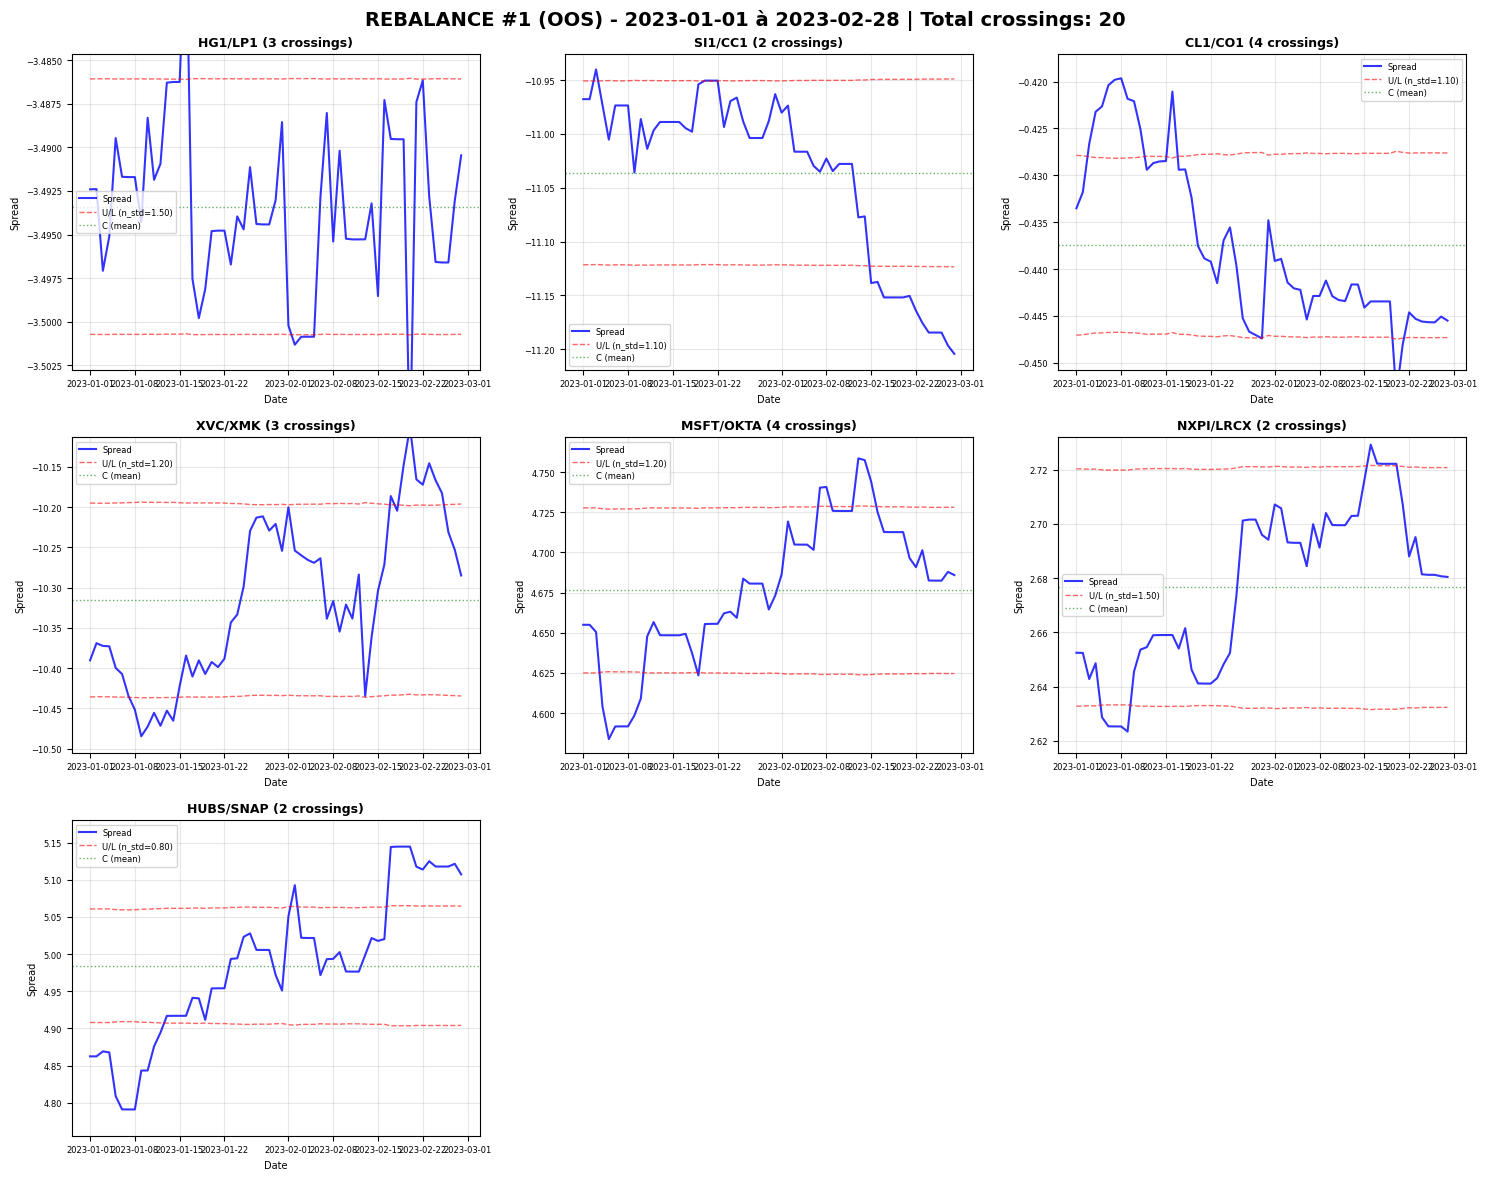

   ✅ 7 paires affichées | 20 crossings de seuils détectés
   Progress: 0/522 dates (0.0%)

  REBALANCE #2 - 2023-03-01


🔷 CRYPTO: Sélection de 3 paires
   📊 Période: 2022-03-01 00:00:00 → 2023-02-28 00:00:00
   🔢 Tickers: 21
   ✅ 1 paires sélectionnées
      - XMK Curncy / XLMUSD Curncy (p=0.0289, HL=13.3)

🔷 COMMODITIES: Sélection de 3 paires
   📊 Période: 2022-03-01 00:00:00 → 2023-02-28 00:00:00
   🔢 Tickers: 29
   ✅ 3 paires sélectionnées
      - SI1 Comdty / LN1 Comdty (p=0.0000, HL=5.5)
      - CL1 Comdty / CO1 Comdty (p=0.0001, HL=5.2)
      - SB1 Comdty / CC1 Comdty (p=0.0023, HL=7.1)

🔷 TAUX: Sélection de 3 paires
   📊 Période: 2022-03-01 00:00:00 → 2023-02-28 00:00:00
   🔢 Tickers: 41
   ⚠️  Aucune paire sélectionnée

🔷 TECH: Sélection de 3 paires
   📊 Période: 2022-03-01 00:00:00 → 2023-02-28 00:00:00
   🔢 Tickers: 44
   ✅ 3 paires sélectionnées
      - AMD US Equity / OKTA US Equity (p=0.0008, HL=19.8)
      - MSFT US Equity / NOW US Equity (p=0.0020, HL=8.9)
      - NXPI 

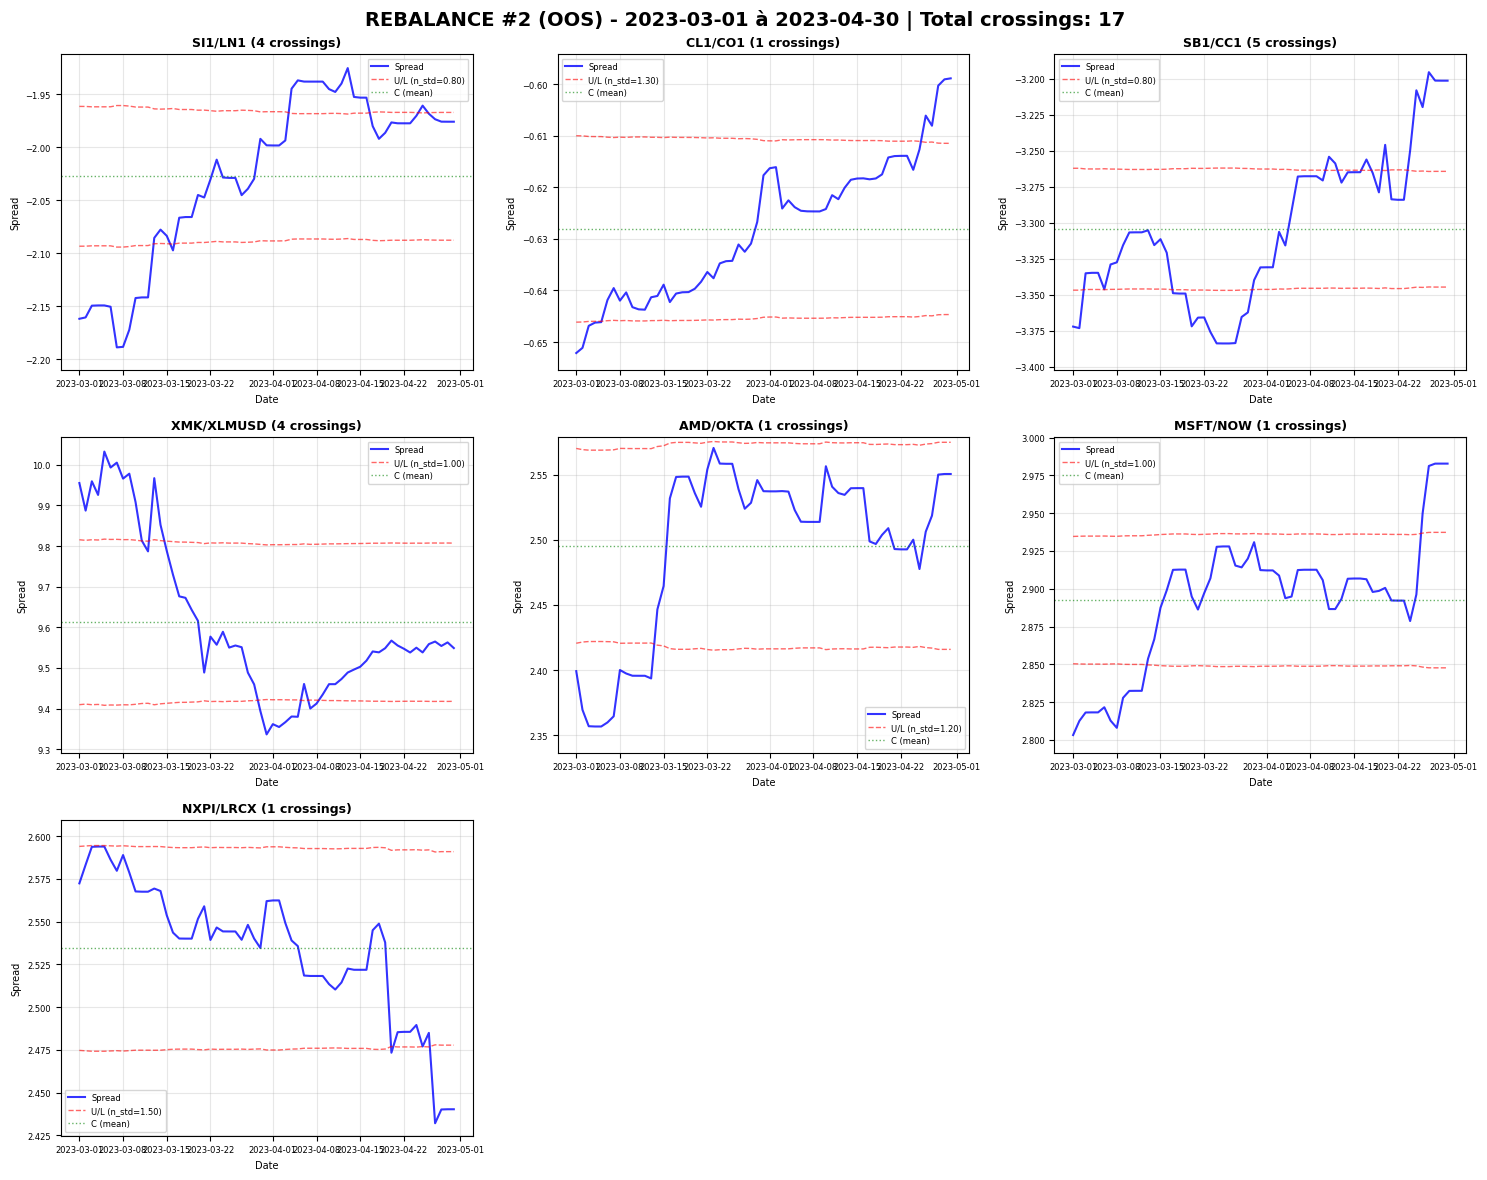

   ✅ 7 paires affichées | 17 crossings de seuils détectés

  REBALANCE #3 - 2023-05-01


🔷 CRYPTO: Sélection de 3 paires
   📊 Période: 2022-05-01 00:00:00 → 2023-04-30 00:00:00
   🔢 Tickers: 21
   ✅ 1 paires sélectionnées
      - XLM Curncy / XMK Curncy (p=0.0437, HL=14.9)

🔷 COMMODITIES: Sélection de 3 paires
   📊 Période: 2022-05-01 00:00:00 → 2023-04-30 00:00:00
   🔢 Tickers: 29
   ✅ 3 paires sélectionnées
      - HG1 Comdty / LP1 Comdty (p=0.0002, HL=2.0)
      - SB1 Comdty / CC1 Comdty (p=0.0015, HL=6.4)
      - LA1 Comdty / S 1 Comdty (p=0.0024, HL=10.0)

🔷 TAUX: Sélection de 3 paires
   📊 Période: 2022-05-02 00:00:00 → 2023-04-28 00:00:00
   🔢 Tickers: 41
   ⚠️  Aucune paire sélectionnée

🔷 TECH: Sélection de 3 paires
   📊 Période: 2022-05-01 00:00:00 → 2023-04-30 00:00:00
   🔢 Tickers: 44
   ✅ 3 paires sélectionnées
      - ASML US Equity / SHOP US Equity (p=0.0019, HL=7.5)
      - NOW US Equity / BIDU US Equity (p=0.0025, HL=10.9)
      - ON US Equity / WDAY US Equity (p=0.005

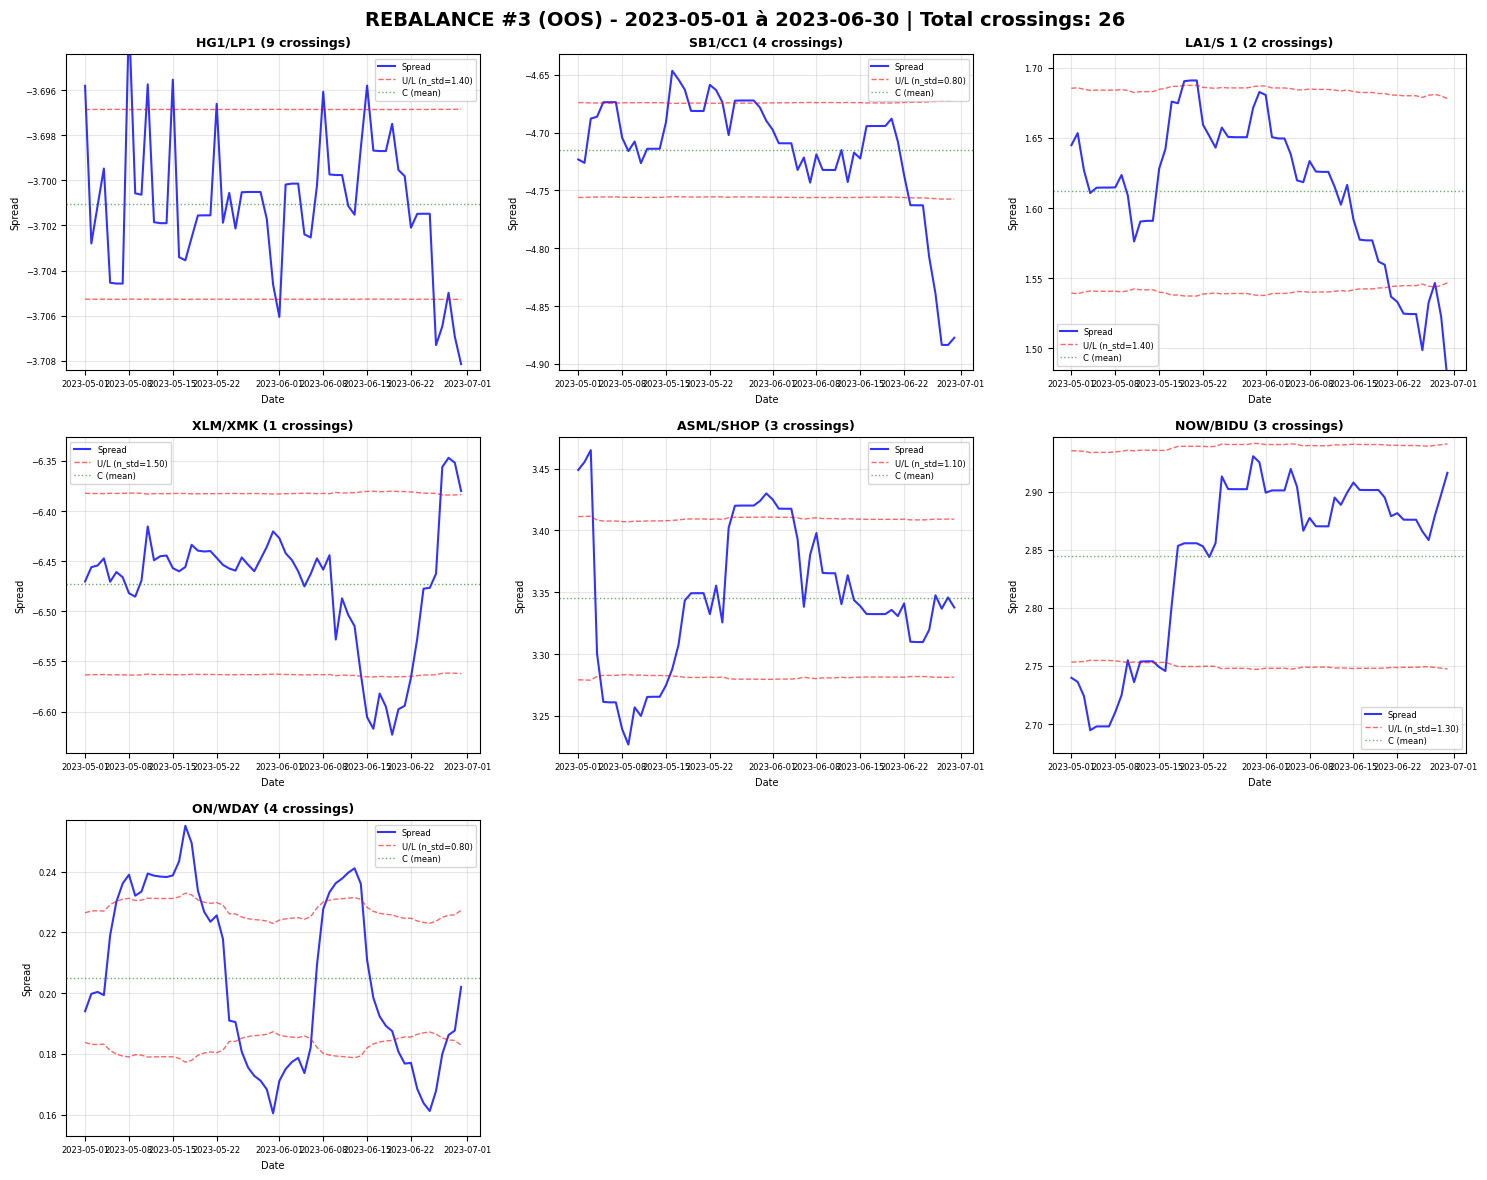

   ✅ 7 paires affichées | 26 crossings de seuils détectés
   ❌ Fermeture: ('tech', 'AMD US Equity', 'OKTA US Equity')

  REBALANCE #4 - 2023-07-01


🔷 CRYPTO: Sélection de 3 paires
   📊 Période: 2022-07-01 00:00:00 → 2023-06-30 00:00:00
   🔢 Tickers: 21
   ✅ 3 paires sélectionnées
      - XET Curncy / BTCUSD Curncy (p=0.0065, HL=11.9)
      - XVC Curncy / XEO Curncy (p=0.0255, HL=17.3)
      - XBT Curncy / ETHUSD Curncy (p=0.0298, HL=17.6)

🔷 COMMODITIES: Sélection de 3 paires
   📊 Période: 2022-07-01 00:00:00 → 2023-06-30 00:00:00
   🔢 Tickers: 29
   ✅ 3 paires sélectionnées
      - HG1 Comdty / LP1 Comdty (p=0.0000, HL=1.7)
      - CL1 Comdty / LB1 Comdty (p=0.0001, HL=7.7)
      - RR1 Comdty / LC1 Comdty (p=0.0008, HL=11.9)

🔷 TAUX: Sélection de 3 paires
   📊 Période: 2022-07-01 00:00:00 → 2023-06-30 00:00:00
   🔢 Tickers: 41
   ⚠️  Aucune paire sélectionnée

🔷 TECH: Sélection de 3 paires
   📊 Période: 2022-07-01 00:00:00 → 2023-06-30 00:00:00
   🔢 Tickers: 44
   ✅ 3 paires sélectio

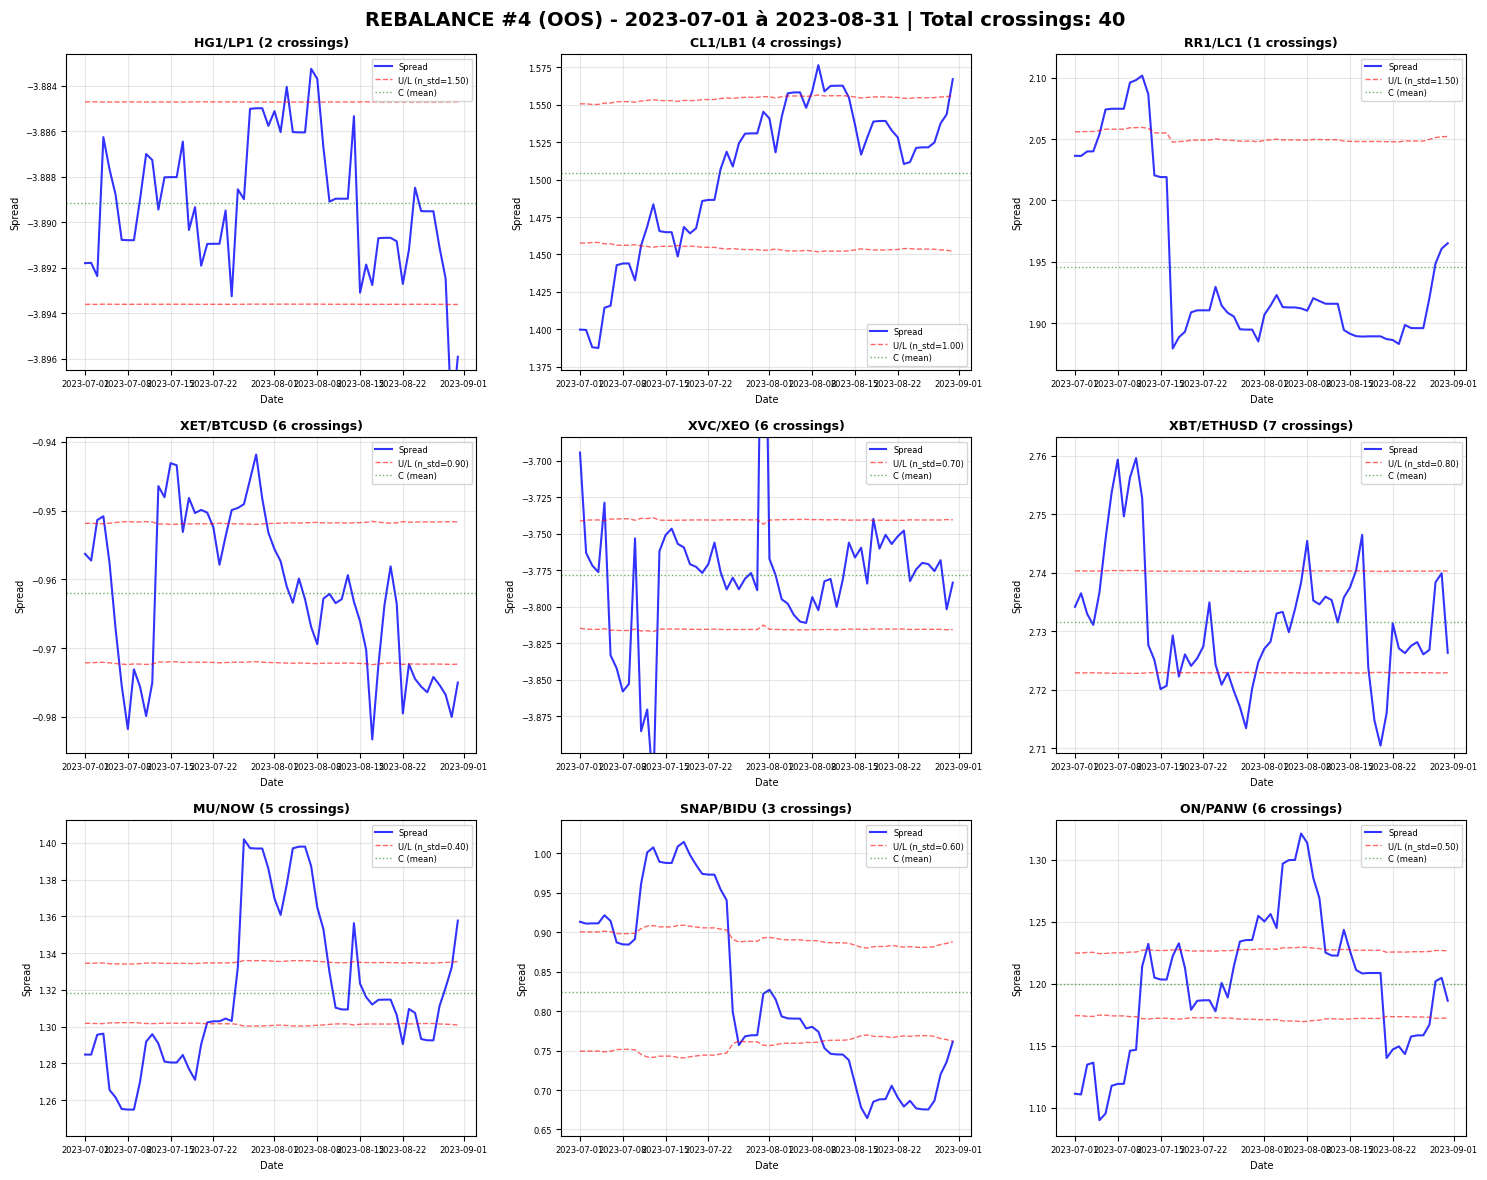

   ✅ 9 paires affichées | 40 crossings de seuils détectés
   ❌ Fermeture: ('commodities', 'LA1 Comdty', 'S 1 Comdty')

  REBALANCE #5 - 2023-09-01


🔷 CRYPTO: Sélection de 3 paires
   📊 Période: 2022-09-01 00:00:00 → 2023-08-31 00:00:00
   🔢 Tickers: 21
   ✅ 3 paires sélectionnées
      - XVC Curncy / XMN Curncy (p=0.0031, HL=4.3)
      - XET Curncy / BTCUSD Curncy (p=0.0047, HL=10.1)
      - XBT Curncy / ETHUSD Curncy (p=0.0093, HL=11.5)

🔷 COMMODITIES: Sélection de 3 paires
   📊 Période: 2022-09-01 00:00:00 → 2023-08-31 00:00:00
   🔢 Tickers: 29
   ✅ 3 paires sélectionnées
      - HG1 Comdty / LP1 Comdty (p=0.0016, HL=2.0)
      - CT1 Comdty / LH1 Comdty (p=0.0037, HL=11.9)
      - CL1 Comdty / HO1 Comdty (p=0.0044, HL=10.3)

🔷 TAUX: Sélection de 3 paires
   📊 Période: 2022-09-01 00:00:00 → 2023-08-31 00:00:00
   🔢 Tickers: 41
   ✅ 3 paires sélectionnées
      - GFRN1 Index / EUR003M Index (p=0.0000, HL=5.1)
      - SOFRRATE Index / EUR001M Index (p=0.0000, HL=3.8)
      - GDBR1 Inde

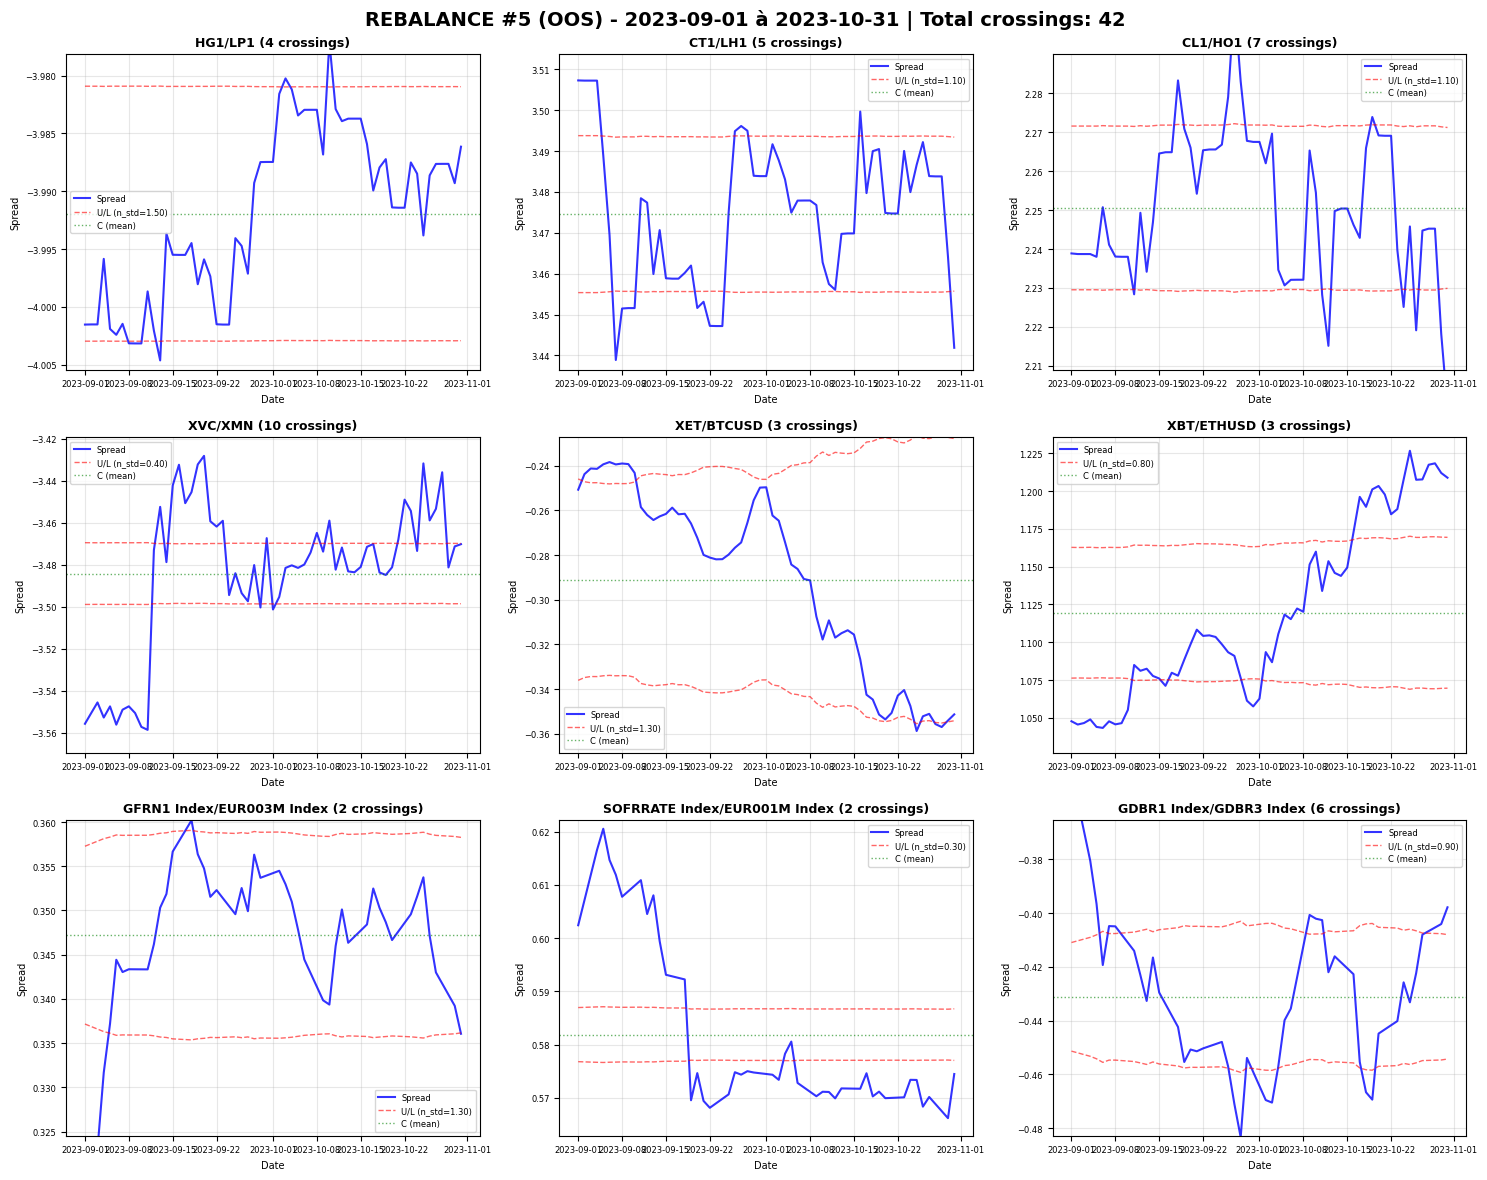

   ✅ 12 paires affichées | 42 crossings de seuils détectés
   ❌ Fermeture: ('tech', 'MU US Equity', 'NOW US Equity')

  REBALANCE #6 - 2023-11-01


🔷 CRYPTO: Sélection de 3 paires
   📊 Période: 2022-11-01 00:00:00 → 2023-10-31 00:00:00
   🔢 Tickers: 21
   ✅ 3 paires sélectionnées
      - XVC Curncy / XMN Curncy (p=0.0043, HL=4.3)
      - XDH Curncy / XEO Curncy (p=0.0064, HL=11.1)
      - XBN Curncy / XMK Curncy (p=0.0223, HL=18.4)

🔷 COMMODITIES: Sélection de 3 paires
   📊 Période: 2022-11-01 00:00:00 → 2023-10-31 00:00:00
   🔢 Tickers: 29
   ✅ 3 paires sélectionnées
      - CT1 Comdty / FC1 Comdty (p=0.0001, HL=6.2)
      - LA1 Comdty / LB1 Comdty (p=0.0007, HL=7.6)
      - HG1 Comdty / SM1 Comdty (p=0.0017, HL=7.5)

🔷 TAUX: Sélection de 3 paires
   📊 Période: 2022-11-01 00:00:00 → 2023-10-31 00:00:00
   🔢 Tickers: 41
   ✅ 3 paires sélectionnées
      - SOFRRATE Index / EUR001M Index (p=0.0000, HL=2.0)
      - GDBR5 Index / GFRN2 Index (p=0.0005, HL=4.0)
      - GDBR7 Index / US0001M

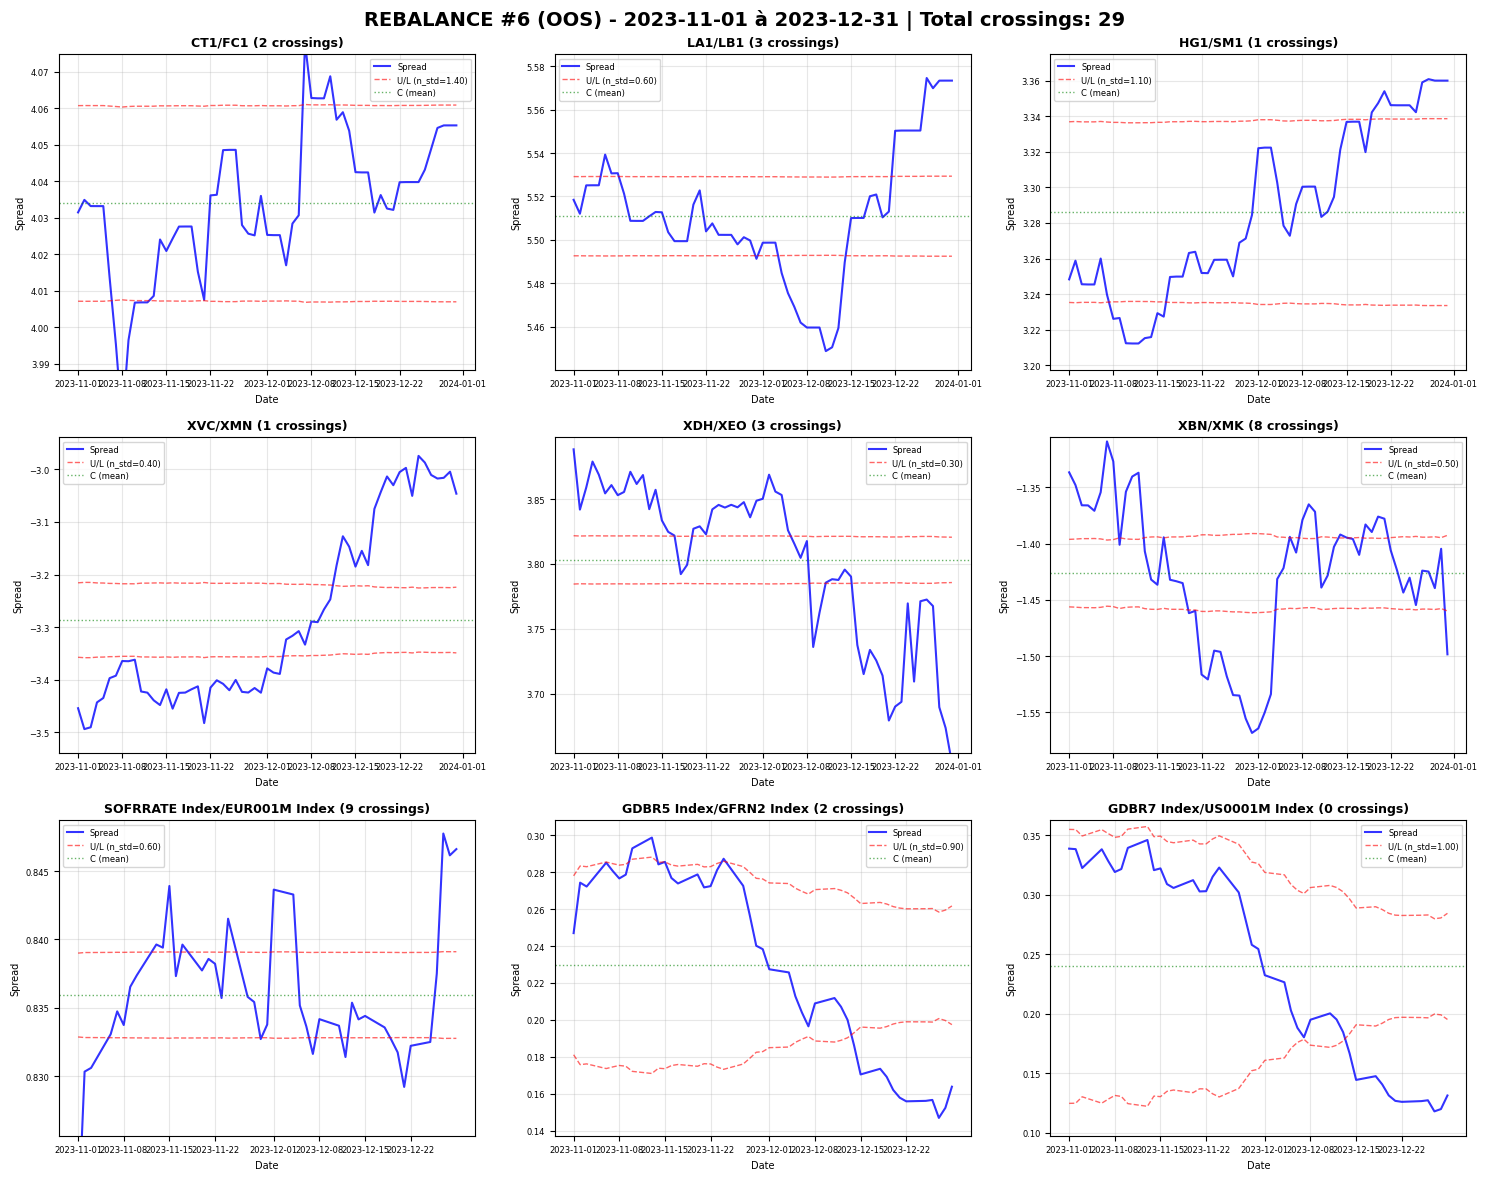

   ✅ 12 paires affichées | 29 crossings de seuils détectés
   ❌ Fermeture: ('tech', 'HUBS US Equity', 'SNAP US Equity')
   ❌ Fermeture: ('commodities', 'HG1 Comdty', 'LP1 Comdty')
   ❌ Fermeture: ('tech', 'ORCL US Equity', 'LRCX US Equity')
   Progress: 250/522 dates (47.9%)

  REBALANCE #7 - 2024-01-01


🔷 CRYPTO: Sélection de 3 paires
   📊 Période: 2023-01-01 00:00:00 → 2023-12-31 00:00:00
   🔢 Tickers: 21
   ⚠️  Aucune paire sélectionnée

🔷 COMMODITIES: Sélection de 3 paires
   📊 Période: 2023-01-01 00:00:00 → 2023-12-31 00:00:00
   🔢 Tickers: 29
   ✅ 3 paires sélectionnées
      - HG1 Comdty / W 1 Comdty (p=0.0007, HL=6.9)
      - NG1 Comdty / PL1 Comdty (p=0.0026, HL=12.0)
      - LA1 Comdty / LB1 Comdty (p=0.0047, HL=9.4)

🔷 TAUX: Sélection de 3 paires
   📊 Période: 2023-01-02 00:00:00 → 2023-12-29 00:00:00
   🔢 Tickers: 41
   ✅ 3 paires sélectionnées
      - EUR001M Index / EUR003M Index (p=0.0007, HL=5.1)
      - GDBR1 Index / GUKG20 Index (p=0.0025, HL=6.1)
      - SOFRRATE In

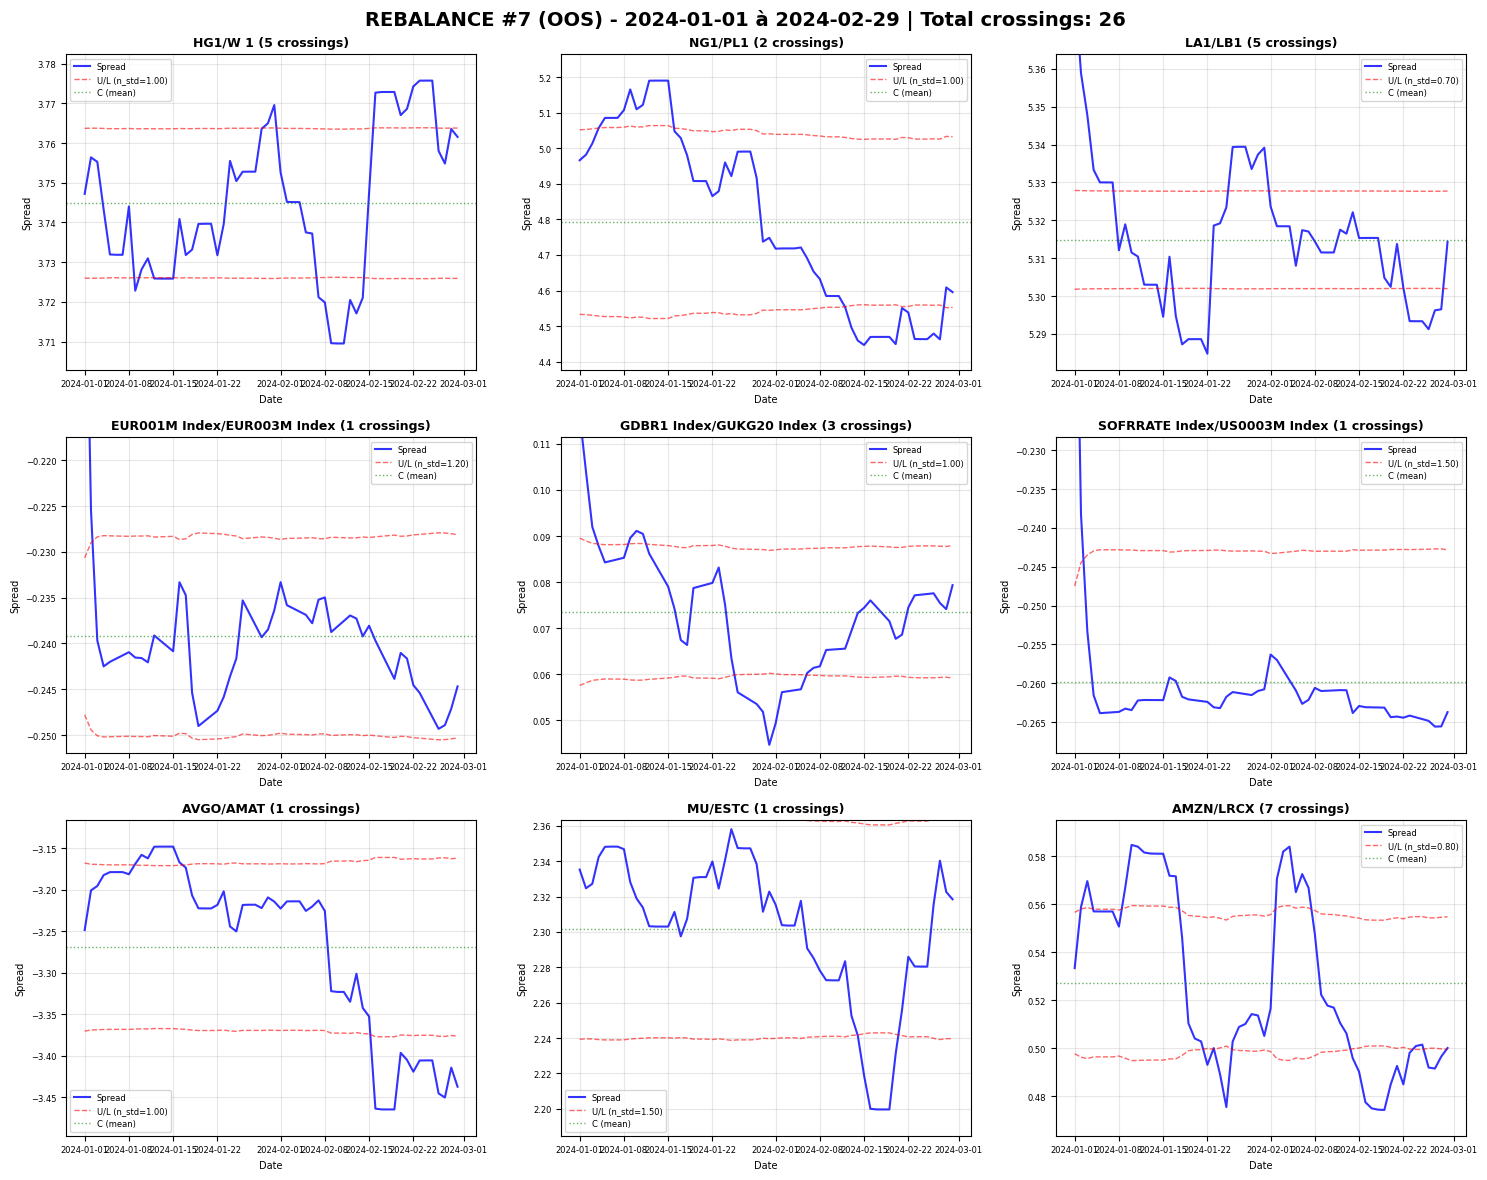

   ✅ 9 paires affichées | 26 crossings de seuils détectés
   ❌ Fermeture: ('crypto', 'XDH Curncy', 'XEO Curncy')
   ❌ Fermeture: ('commodities', 'CT1 Comdty', 'FC1 Comdty')

  REBALANCE #8 - 2024-03-01


🔷 CRYPTO: Sélection de 3 paires
   📊 Période: 2023-03-01 00:00:00 → 2024-02-29 00:00:00
   🔢 Tickers: 21
   ✅ 1 paires sélectionnées
      - XTH Curncy / XVC Curncy (p=0.0079, HL=8.4)

🔷 COMMODITIES: Sélection de 3 paires
   📊 Période: 2023-03-01 00:00:00 → 2024-02-29 00:00:00
   🔢 Tickers: 29
   ✅ 3 paires sélectionnées
      - GC1 Comdty / KC1 Comdty (p=0.0000, HL=8.8)
      - LT1 Comdty / LH1 Comdty (p=0.0002, HL=9.3)
      - LA1 Comdty / LB1 Comdty (p=0.0006, HL=8.4)

🔷 TAUX: Sélection de 3 paires
   📊 Période: 2023-03-01 00:00:00 → 2024-02-29 00:00:00
   🔢 Tickers: 41
   ✅ 3 paires sélectionnées
      - SOFRRATE Index / EUR003M Index (p=0.0004, HL=4.3)
      - TU1 Comdty / GDBR1 Index (p=0.0015, HL=5.6)
      - G 1 Comdty / GFRN1 Index (p=0.0017, HL=5.0)

🔷 TECH: Sélection de 3 pa

KeyboardInterrupt: 

In [43]:
# Pour Model 2 (Strat C) - par défaut
df_portfolio_pnl_2_C = run_portfolio_backtest(
    asset_classes=ASSET_CLASSES,
    backtest_start=BACKTEST_START,
    backtest_end=BACKTEST_END,
    rebalance_freq_months=REBALANCE_FREQ_MONTHS,
    lookback_years=SELECTION_LOOKBACK_YEARS,
    n_pairs_per_class=N_PAIRS_PER_CLASS,
    model="II"  # Strat C (hétéroscédastique)
)

print(df_portfolio_pnl_2_C.head())

print(f"\n📊 Résultats du backtest:")
print(f"   Dates: {len(df_portfolio_pnl_2_C)}")
print(f"   PnL moyen par jour: {df_portfolio_pnl_2_C['pnl'].mean():.6f}")
print(f"   Positions moyennes: {df_portfolio_pnl_2_C['n_positions'].mean():.1f}")

In [ ]:
# Pour Model 1 (Strat A)
df_portfolio_pnl_1_A = run_portfolio_backtest(
    asset_classes=ASSET_CLASSES,
    backtest_start=BACKTEST_START,
    backtest_end=BACKTEST_END,
    rebalance_freq_months=REBALANCE_FREQ_MONTHS,
    lookback_years=SELECTION_LOOKBACK_YEARS,
    n_pairs_per_class=N_PAIRS_PER_CLASS,
    model="I"  # Strat A (homoscédastique)
)

print(f"\n📊 Résultats du backtest:")
print(f"   Dates: {len(df_portfolio_pnl_1_A)}")
print(f"   PnL moyen par jour: {df_portfolio_pnl_1_A['pnl'].mean():.6f}")
print(f"   Positions moyennes: {df_portfolio_pnl_1_A['n_positions'].mean():.1f}")

## 📈 Performance Metrics & Analysis

In [ ]:
# ============================================================================
# VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# 1. Cumulative P&L
cum_pnl = df_portfolio_pnl_2_C['pnl'].cumsum()
axes[0, 0].plot(cum_pnl.index, cum_pnl.values, linewidth=2)
axes[0, 0].set_title('Cumulative P&L', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Cumulative P&L')
axes[0, 0].grid(True, alpha=0.3)

# 2. Drawdown
cum_max = np.maximum.accumulate(cum_pnl.values)
drawdown = cum_pnl.values - cum_max
axes[0, 1].fill_between(cum_pnl.index, drawdown, 0, alpha=0.5, color='red')
axes[0, 1].set_title('Drawdown', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Drawdown')
axes[0, 1].grid(True, alpha=0.3)

# 3. Daily P&L Distribution
axes[1, 0].hist(df_portfolio_pnl_2_C['pnl'], bins=50, alpha=0.7, edgecolor='black')
axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_title('Daily P&L Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Daily P&L')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)

# 4. Rolling Sharpe Ratio (60 days)
rolling_mean = df_portfolio_pnl_2_C['pnl'].rolling(60).mean()
rolling_std = df_portfolio_pnl_2_C['pnl'].rolling(60).std()
rolling_sharpe = (rolling_mean * 252 - 0.02) / (rolling_std * np.sqrt(252))

axes[1, 1].plot(rolling_sharpe.index, rolling_sharpe.values, linewidth=2)
axes[1, 1].axhline(0, color='red', linestyle='--', linewidth=1)
axes[1, 1].set_title('Rolling Sharpe Ratio (60 days)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Sharpe Ratio')
axes[1, 1].grid(True, alpha=0.3)

# 5. Number of Active Positions Over Time
axes[2, 0].plot(df_portfolio_pnl_2_C.index, df_portfolio_pnl_2_C['n_positions'], linewidth=2, color='green')
axes[2, 0].set_title('Active Positions Over Time', fontsize=12, fontweight='bold')
axes[2, 0].set_xlabel('Date')
axes[2, 0].set_ylabel('N Positions')
axes[2, 0].grid(True, alpha=0.3)

# 6. Rebalance Periods
colors = plt.cm.tab10(np.linspace(0, 1, df_portfolio_pnl_2_C['rebalance_period'].nunique()))
for i, period in enumerate(df_portfolio_pnl_2_C['rebalance_period'].unique()):
    mask = df_portfolio_pnl_2_C['rebalance_period'] == period
    period_cum_pnl = df_portfolio_pnl_2_C.loc[mask, 'pnl'].cumsum()
    axes[2, 1].plot(period_cum_pnl.index, period_cum_pnl.values, 
                   label=f'Period {int(period)}', linewidth=1.5, color=colors[i])

axes[2, 1].set_title('Cumulative P&L by Rebalance Period', fontsize=12, fontweight='bold')
axes[2, 1].set_xlabel('Date')
axes[2, 1].set_ylabel('Period Cumulative P&L')
axes[2, 1].legend(fontsize=8, loc='best')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Data/portfolio_performance.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Graphiques sauvegardés: Data/portfolio_performance_2_C.png")

In [ ]:
# ============================================================================
# ADVANCED PERFORMANCE METRICS
# ============================================================================

def calculate_performance_metrics(df_pnl: pd.DataFrame, benchmark_return: float = 0.02, initial_capital: float = 1.0) -> Dict:
    """
    Calcule les métriques de performance avancées.
    
    Args:
        df_pnl: DataFrame avec colonnes 'pnl' (PnL quotidien moyen par paire)
        benchmark_return: Taux sans risque annualisé
        initial_capital: Capital notionnel de référence par paire (défaut=1.0 pour des returns normalisés)
    
    Metrics:
    - Alpha: excess return vs risk-free rate
    - Information Ratio (IR): alpha / tracking error
    - Information Coefficient (IC): correlation between forecasts and returns
    - Breadth: number of independent bets
    - Skill (IC): forecasting skill
    - Fundamental Law: IR ≈ IC * sqrt(Breadth)
    
    Note: pnl est le PnL quotidien MOYEN sur toutes les paires actives (équipondéré).
    On le convertit en return % en divisant par initial_capital.
    """
    
    pnl = df_pnl['pnl'].values
    n_obs = len(pnl)
    
    # Convertir PnL en returns % (basé sur capital notionnel de 1.0 par paire)
    daily_returns = pnl / initial_capital
    
    # Cumulative returns (composé)
    cum_returns = (1 + daily_returns).cumprod() - 1
    total_return = cum_returns[-1]
    
    # Annualized return (composé)
    years = n_obs / 252.0
    ann_return = (1 + total_return) ** (1 / years) - 1 if years > 0 else 0
    
    # Volatility
    daily_vol = np.std(pnl)
    ann_vol = daily_vol * np.sqrt(252.0)
    
    # Sharpe Ratio
    ann_excess_return = ann_return - benchmark_return
    sharpe_ratio = ann_excess_return / ann_vol if ann_vol > 0 else 0
    
    # Alpha (excess return)
    alpha = ann_excess_return
    
    # Information Ratio (assumes benchmark = risk-free)
    # IR = E[R_p - R_b] / σ(R_p - R_b)
    tracking_error = ann_vol  # Since benchmark is constant
    information_ratio = alpha / tracking_error if tracking_error > 0 else 0
    
    # Information Coefficient (approximation)
    # IC ≈ correlation between period returns (proxy for forecast quality)
    # Simplified: autocorrelation of returns as proxy
    if len(pnl) > 1:
        ic = np.corrcoef(pnl[:-1], pnl[1:])[0, 1]
    else:
        ic = 0
    
    # Breadth: number of independent bets
    # Approximation: average number of active positions * rebalancing frequency
    n_positions_avg = df_pnl['n_positions'].mean()
    n_rebalances = len(df_pnl['rebalance_period'].unique())
    breadth = n_positions_avg * n_rebalances
    
    # Skill (from Fundamental Law)
    # IR = IC * sqrt(Breadth) => IC = IR / sqrt(Breadth)
    skill = information_ratio / np.sqrt(breadth) if breadth > 0 else 0
    
    # Maximum Drawdown
    cum_max = np.maximum.accumulate(cum_returns)
    drawdown = cum_returns - cum_max
    max_drawdown = np.min(drawdown)
    
    return {
        'Total Return': total_return,
        'Annualized Return': ann_return,
        'Annualized Volatility': ann_vol,
        'Sharpe Ratio': sharpe_ratio,
        'Alpha': alpha,
        'Information Ratio': information_ratio,
        'Information Coefficient': ic,
        'Breadth': breadth,
        'Skill (IC from FL)': skill,
        'Max Drawdown': max_drawdown
    }


# Calculer les métriques
metrics = calculate_performance_metrics(df_portfolio_pnl_2_C)

print(f"\n{'='*80}")
print(f"  PERFORMANCE METRICS")
print(f"{'='*80}\n")

for key, value in metrics.items():
    if isinstance(value, float):
        print(f"  {key:.<40} {value:>12.4f}")
    else:
        print(f"  {key:.<40} {value:>12}")

# Vérification du Fundamental Law of Active Management
# IR = IC * sqrt(BR)
predicted_ir = metrics['Skill (IC from FL)'] * np.sqrt(metrics['Breadth'])
print(f"\n{'='*80}")
print(f"  FUNDAMENTAL LAW VERIFICATION")
print(f"{'='*80}")
print(f"  Actual IR: {metrics['Information Ratio']:.4f}")
print(f"  Predicted IR (IC × √BR): {predicted_ir:.4f}")
print(f"  Difference: {abs(metrics['Information Ratio'] - predicted_ir):.4f}")

In [ ]:
# ============================================================================
# VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# 1. Cumulative P&L
cum_pnl = df_portfolio_pnl_1_A['pnl'].cumsum()
axes[0, 0].plot(cum_pnl.index, cum_pnl.values, linewidth=2)
axes[0, 0].set_title('Cumulative P&L', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Cumulative P&L')
axes[0, 0].grid(True, alpha=0.3)

# 2. Drawdown
cum_max = np.maximum.accumulate(cum_pnl.values)
drawdown = cum_pnl.values - cum_max
axes[0, 1].fill_between(cum_pnl.index, drawdown, 0, alpha=0.5, color='red')
axes[0, 1].set_title('Drawdown', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Drawdown')
axes[0, 1].grid(True, alpha=0.3)

# 3. Daily P&L Distribution
axes[1, 0].hist(df_portfolio_pnl_1_A['pnl'], bins=50, alpha=0.7, edgecolor='black')
axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_title('Daily P&L Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Daily P&L')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)

# 4. Rolling Sharpe Ratio (60 days)
rolling_mean = df_portfolio_pnl_1_A['pnl'].rolling(60).mean()
rolling_std = df_portfolio_pnl_1_A['pnl'].rolling(60).std()
rolling_sharpe = (rolling_mean * 252 - 0.02) / (rolling_std * np.sqrt(252))

axes[1, 1].plot(rolling_sharpe.index, rolling_sharpe.values, linewidth=2)
axes[1, 1].axhline(0, color='red', linestyle='--', linewidth=1)
axes[1, 1].set_title('Rolling Sharpe Ratio (60 days)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Sharpe Ratio')
axes[1, 1].grid(True, alpha=0.3)

# 5. Number of Active Positions Over Time
axes[2, 0].plot(df_portfolio_pnl_1_A.index, df_portfolio_pnl_1_A['n_positions'], linewidth=2, color='green')
axes[2, 0].set_title('Active Positions Over Time', fontsize=12, fontweight='bold')
axes[2, 0].set_xlabel('Date')
axes[2, 0].set_ylabel('N Positions')
axes[2, 0].grid(True, alpha=0.3)

# 6. Rebalance Periods
colors = plt.cm.tab10(np.linspace(0, 1, df_portfolio_pnl_1_A['rebalance_period'].nunique()))
for i, period in enumerate(df_portfolio_pnl_1_A['rebalance_period'].unique()):
    mask = df_portfolio_pnl_1_A['rebalance_period'] == period
    period_cum_pnl = df_portfolio_pnl_1_A.loc[mask, 'pnl'].cumsum()
    axes[2, 1].plot(period_cum_pnl.index, period_cum_pnl.values, 
                   label=f'Period {int(period)}', linewidth=1.5, color=colors[i])

axes[2, 1].set_title('Cumulative P&L by Rebalance Period', fontsize=12, fontweight='bold')
axes[2, 1].set_xlabel('Date')
axes[2, 1].set_ylabel('Period Cumulative P&L')
axes[2, 1].legend(fontsize=8, loc='best')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Data/portfolio_performance.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Graphiques sauvegardés: Data/portfolio_performance_1_A.png")

In [ ]:
# Calculer les métriques
metrics = calculate_performance_metrics(df_portfolio_pnl_1_A)

print(f"\n{'='*80}")
print(f"  PERFORMANCE METRICS")
print(f"{'='*80}\n")

for key, value in metrics.items():
    if isinstance(value, float):
        print(f"  {key:.<40} {value:>12.4f}")
    else:
        print(f"  {key:.<40} {value:>12}")

# Vérification du Fundamental Law of Active Management
# IR = IC * sqrt(BR)
predicted_ir = metrics['Skill (IC from FL)'] * np.sqrt(metrics['Breadth'])
print(f"\n{'='*80}")
print(f"  FUNDAMENTAL LAW VERIFICATION")
print(f"{'='*80}")
print(f"  Actual IR: {metrics['Information Ratio']:.4f}")
print(f"  Predicted IR (IC × √BR): {predicted_ir:.4f}")
print(f"  Difference: {abs(metrics['Information Ratio'] - predicted_ir):.4f}")

In [ ]:
def make_weekly(df: pd.DataFrame) -> pd.DataFrame:
    """
    df doit avoir: 'pnl' (daily return) et 'forecast' (daily signal)
    Sortie weekly:
      - ret_w : return composé sur la semaine
      - forecast_w : forecast pris au dernier jour de la semaine
    """
    out = pd.DataFrame(index=df.index.copy())

    # return daily (déjà un return chez toi car capital notionnel = 1)
    out["ret_d"] = df["pnl"].astype(float)

    # forecast daily
    if "forecast" in df.columns:
        out["forecast_d"] = df["forecast"].astype(float)
    else:
        out["forecast_d"] = 0.0

    # Weekly compounded returns: (1+r1)...(1+rk)-1
    ret_w = (1.0 + out["ret_d"]).resample("W-FRI").prod() - 1.0

    # Weekly forecast: dernier point de la semaine (Friday close)
    forecast_w = out["forecast_d"].resample("W-FRI").last()

    df_w = pd.DataFrame({"ret_w": ret_w, "forecast_w": forecast_w}).dropna()
    return df_w


In [ ]:
def information_coefficient_weekly(df_w: pd.DataFrame, horizon_weeks: int = 1) -> float:
    """
    IC = corr(forecast_t, return_{t+h})
    """
    future_ret = df_w["ret_w"].shift(-horizon_weeks)
    return df_w["forecast_w"].corr(future_ret)

def active_information_ratio_weekly(df_main_w: pd.DataFrame, df_bench_w: pd.DataFrame) -> float:
    """
    IR = mean(active_return) / std(active_return)
    Sur base weekly.
    """
    joined = df_main_w[["ret_w"]].join(df_bench_w[["ret_w"]], how="inner", lsuffix="_main", rsuffix="_bench")
    active = joined["ret_w_main"] - joined["ret_w_bench"]
    if active.std(ddof=1) < 1e-12:
        return 0.0
    return active.mean() / active.std(ddof=1)



In [ ]:
df_main_w  = make_weekly(df_portfolio_pnl_2_C)   # Strat C / Model II
df_bench_w = make_weekly(df_portfolio_pnl_1_A)    # Strat A / Model I

ic_w = information_coefficient_weekly(df_main_w, horizon_weeks=1)
ir_w = active_information_ratio_weekly(df_main_w, df_bench_w)

print("Weekly IC (forecast vs next week return):", ic_w)
print("Weekly Active IR (Model II vs Model I):", ir_w)

ir_ann = ir_w * np.sqrt(52)
print("Active IR annualized:", ir_ann)


In [ ]:
breadth_w = df_portfolio_pnl_2_C["n_positions"].resample("W-FRI").mean().mean()
print("Breadth weekly proxy:", breadth_w)



In [ ]:
pred_ir = ic_w * np.sqrt(breadth_w)
print("Predicted IR (IC * sqrt(BR)):", pred_ir)
print("Gap:", ir_w - pred_ir)


In [ ]:
breadth_eff = (ir_w / ic_w)**2 if abs(ic_w) > 1e-12 else np.nan
print("Implied breadth (from IR and IC):", breadth_eff)


In [ ]:
def alpha_active_weekly(df_main_w: pd.DataFrame, df_bench_w: pd.DataFrame):
    joined = df_main_w[["ret_w"]].join(df_bench_w[["ret_w"]], how="inner", lsuffix="_main", rsuffix="_bench")
    active = joined["ret_w_main"] - joined["ret_w_bench"]

    alpha_w = active.mean()
    te_w = active.std(ddof=1)

    alpha_ann = alpha_w * 52
    te_ann = te_w * np.sqrt(52)
    ir_ann = alpha_ann / te_ann if te_ann > 1e-12 else 0.0

    return {
        "Alpha_weekly": alpha_w,
        "Alpha_annualized": alpha_ann,
        "TrackingError_weekly": te_w,
        "TrackingError_annualized": te_ann,
        "InformationRatio_annualized": ir_ann
    }


In [ ]:
df_main_w  = make_weekly(df_portfolio_pnl_2_C)
df_bench_w = make_weekly(df_portfolio_pnl_1_A)

alpha_stats = alpha_active_weekly(df_main_w, df_bench_w)
alpha_stats
# Skill is not computed separately because it is equivalent to the IC; using IR/sqrt(Breadth)
# would be misleading since our Breadth is only a proxy and not true independent bets.
